In [171]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import graphviz
from sklearn import preprocessing,model_selection
import itertools
import datetime
import math

## 1、原始数据
`结论:`
- tag=1表示违约，tag=0表示没有违约
- 训练数据和评分数据中，交易数据trd和APP使用数据beh中的用户id都来自于用户所有信息汇总表tag。
- 目的是求出评分数据集中用户的违约概率。

In [585]:
tag_data=pd.read_csv(r'C:\Users\Huiqin Xie\Desktop\招商银行\训练数据集\训练数据集\训练数据集_tag.csv')
tag_data

,id,flag,gdr_cd,age,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,job_year,ic_ind,...,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl
0,U7A4BAD,0,M,41,B,B,Z,NaN,3,0,...,-1,0,0,0,3,1,0,3492,-1,10
1,U557810,0,M,35,A,NaN,G,NaN,4,0,...,-1,0,0,0,1,1,0,4575,-1,10
2,U1E9240,0,M,53,B,A,C,C,9,0,...,-1,0,0,0,7,2,0,4894,-1,40
3,U6DED00,0,F,41,B,NaN,Z,NaN,0,0,...,-1,0,0,0,1,1,0,4938,-1,10
4,UDA8E28,0,F,42,B,B,Z,B,3,1,...,-1,0,0,0,2,7,0,2378,-1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39918,U8E66E5,1,M,24,A,NaN,G,NaN,1,0,...,20,1,1,NaN,1,0,1,-1,165,0
39919,U70BACF,0,M,41,B,NaN,G,NaN,1,0,...,20,1,0,NaN,1,0,2,-1,166,0
39920,U777E7D,0,M,29,A,NaN,G,NaN,0,0,...,20,0,0,NaN,3,0,1,-1,166,0
39921,UE77AAD,0,M,31,A,NaN,31,NaN,0,0,...,20,0,0,NaN,3,0,1,-1,166,0


In [586]:
trd_data=pd.read_csv(r'C:\Users\Huiqin Xie\Desktop\招商银行\训练数据集\训练数据集\训练数据集_trd.csv')
trd_data

,id,flag,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt
0,UFDC88A,0,B,B,1,116,2019-06-20 07:15:28,-127.99
1,UFDC88A,0,B,B,1,116,2019-06-16 10:09:13,-55.88
2,UFDC88A,0,B,B,1,136,2019-05-14 16:11:32,-557.00
3,UFDC88A,0,B,B,1,136,2019-05-19 21:54:40,-77.80
4,UFDC88A,0,B,B,1,113,2019-06-18 08:23:59,-271.62
...,...,...,...,...,...,...,...,...
1367206,UB2CD74,0,B,B,3,310,2019-06-24 15:16:12,-882.00
1367207,UB2CD74,0,B,B,1,134,2019-05-24 15:16:12,-61.52
1367208,UB2CD74,0,B,B,3,310,2019-05-24 15:16:12,-882.00
1367209,UB2CD74,0,B,B,1,134,2019-06-24 15:16:12,-61.52


In [587]:
beh_data=pd.read_csv(r'C:\Users\Huiqin Xie\Desktop\招商银行\训练数据集\训练数据集\训练数据集_beh.csv')
# beh_data.drop('page_tm',axis=1,inplace=True)
# beh_data.rename({'Unnamed: 3':'page_tm'},axis=1,inplace=True)
beh_data

,id,flag,page_no,page_tm
0,U64F0C9,0,SZA,2019/6/30 12:44
1,U64F0C9,0,CQE,2019/6/25 16:15
2,U64F0C9,0,AAO,2019/6/30 12:44
3,U64F0C9,0,CQE,2019/6/17 13:50
4,U64F0C9,0,AAO,2019/6/17 13:50
...,...,...,...,...
934277,U758CA5,0,XAG,2019/6/1 16:47
934278,U758CA5,0,CQA,2019/6/26 7:02
934279,U758CA5,0,CQE,2019/6/26 7:02
934280,U758CA5,0,CQE,2019/6/26 8:16


In [588]:
#trd用户是tag用户的子集
set(trd_data['id']).issubset(set(tag_data['id']))

True

In [589]:
#beh用户是tag用户的子集
set(beh_data['id']).issubset(set(tag_data['id']))

True

In [590]:
set(trd_data['id']).issubset(set(beh_data))

False

In [591]:
#beh_data_id and trd_data_id 有交集
set(beh_data['id']).issubset(set(trd_data))

False

In [592]:
mark_tag_data=pd.read_csv(r'C:\Users\Huiqin Xie\Desktop\招商银行\评分数据集b\b\评分数据集_tag_b.csv')
mark_tag_data


,id,gdr_cd,age,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,job_year,ic_ind,fr_or_sh_ind,...,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl
0,U1E63A3,M,40,B,C,31,NaN,1,0,1,...,25,1,5,0.0,7,1,1,4047,4260,10
1,U3EC77F,M,46,A,C,31,NaN,3,0,0,...,10,0,0,0.0,4,2,1,5460,3317,10
2,U27DC0C,M,42,B,F,G,NaN,3,0,0,...,10,1,5,1.0,7,3,2,4103,4108,10
3,U3FAAAC,F,35,B,B,30,NaN,5,0,1,...,20,0,0,0.0,3,3,1,4733,4748,20
4,U04EA0B,M,34,A,F,G,NaN,9,0,0,...,10,1,3,1.0,7,6,2,4525,1670,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,U0FBFE2,F,58,B,B,30,A,29,0,0,...,20,0,0,0.0,7,2,1,5341,4413,40
3996,U506AD2,M,50,B,C,31,~,25,0,0,...,20,0,0,0.0,3,1,1,3118,677,20
3997,U287B33,M,39,A,Z,Z,~,0,1,1,...,20,0,0,0.0,5,2,1,348,313,20
3998,U15134F,M,34,A,B,30,~,2,0,0,...,10,1,2,0.0,3,1,1,3476,3774,10


In [593]:
mark_trd_data=pd.read_csv(r'C:\Users\Huiqin Xie\Desktop\招商银行\评分数据集b\b\评分数据集_trd_b.csv')
mark_trd_data

,id,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt
0,U452CA2,B,B,1,130,2019-06-01 00:29:32,-5.00
1,U452CA2,B,B,1,136,2019-05-15 00:00:00,-37.19
2,U452CA2,C,B,3,309,2019-05-30 13:22:08,249.47
3,U452CA2,B,B,1,108,2019-05-30 14:37:13,-29.94
4,U452CA2,B,B,1,136,2019-06-21 00:00:00,-111.31
...,...,...,...,...,...,...,...
142640,U312898,B,B,3,310,2019-06-08 19:47:02,-1500.00
142641,U312898,C,B,3,309,2019-06-29 07:25:09,1.16
142642,U312898,C,B,3,309,2019-06-29 17:57:56,1871.00
142643,U312898,B,B,1,134,2019-05-08 19:47:02,-118.80


In [594]:
mark_beh_data=pd.read_csv(r'C:\Users\Huiqin Xie\Desktop\招商银行\评分数据集b\b\评分数据集_beh_b.csv')
# mark_beh_data.drop('page_tm',axis=1,inplace=True)
# mark_beh_data.rename({'Unnamed: 2':'page_tm'},axis=1,inplace=True)
mark_beh_data


,id,page_no,page_tm
0,U441F8F,CQA,2019/6/11 22:27
1,U441F8F,XAI,2019/6/17 17:42
2,U441F8F,CQA,2019/6/17 17:42
3,U441F8F,XAI,2019/6/17 17:42
4,U441F8F,CQE,2019/6/17 17:42
...,...,...,...
95664,U46C5B4,CQE,2019/6/2 23:44
95665,U46C5B4,CQA,2019/6/12 18:11
95666,U46C5B4,CQA,2019/6/25 12:29
95667,U46C5B4,CQE,2019/6/26 9:19


In [595]:
#将训练集与测试集合并
tag_data=pd.concat((tag_data,mark_tag_data),axis=0)
trd_data=pd.concat((trd_data,mark_trd_data),axis=0)
beh_data=pd.concat((beh_data,mark_beh_data),axis=0)

In [596]:
trd_data

,id,flag,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt
0,UFDC88A,0.0,B,B,1,116,2019-06-20 07:15:28,-127.99
1,UFDC88A,0.0,B,B,1,116,2019-06-16 10:09:13,-55.88
2,UFDC88A,0.0,B,B,1,136,2019-05-14 16:11:32,-557.00
3,UFDC88A,0.0,B,B,1,136,2019-05-19 21:54:40,-77.80
4,UFDC88A,0.0,B,B,1,113,2019-06-18 08:23:59,-271.62
...,...,...,...,...,...,...,...,...
142640,U312898,NaN,B,B,3,310,2019-06-08 19:47:02,-1500.00
142641,U312898,NaN,C,B,3,309,2019-06-29 07:25:09,1.16
142642,U312898,NaN,C,B,3,309,2019-06-29 17:57:56,1871.00
142643,U312898,NaN,B,B,1,134,2019-05-08 19:47:02,-118.80


## 2、三表合并

### 2.1 将trd并入tag

In [601]:
train_dfm=tag_data.copy()
#tag_data与trd_data
#trd_count:交易次数
trd_count=pd.DataFrame(trd_data.groupby(by='id')['cny_trx_amt'].aggregate('count'))
trd_count.rename(columns={'cny_trx_amt':'trd_count'},inplace=True)
train_dfm=train_dfm.merge(trd_count,on='id',how='left')
train_dfm['trd_count'].fillna(0,inplace=True)
#trd_amount:交易金额
trd_data['Dat_Flg1_Cd_num']=trd_data['Dat_Flg1_Cd'].apply(lambda x:1 if x=='C' else -1)
trd_data['cny_trx_amt_handled']=trd_data['cny_trx_amt']*trd_data['Dat_Flg1_Cd_num']
trd_amount=pd.DataFrame(trd_data.groupby(by='id')['cny_trx_amt_handled'].aggregate(sum))
trd_amount.rename(columns={'cny_trx_amt_handled':'trd_amount'},inplace=True)
train_dfm=train_dfm.merge(trd_amount,on='id',how='left')
train_dfm['trd_amount'].fillna(0,inplace=True)
#交易分类取最高频Trx_Cod1_Cd,Trx_Cod2_Cd
Trx_Cod1_Cd=trd_data.groupby(by='id')['Trx_Cod1_Cd'].aggregate(max)
Trx_Cod2_Cd=trd_data.groupby(by='id')['Trx_Cod2_Cd'].aggregate(max)
#交易时间距end_time时长的均值和最小值:trd_time_delta_mea,trd_time_delta_min
trd_data['trx_tm']=pd.to_datetime(trd_data['trx_tm'])
endtime=datetime.datetime(2019,6,30)
trd_data['trd_time_delta']=endtime-trd_data['trx_tm']
trd_data['trd_time_delta']=trd_data['trd_time_delta'].astype('timedelta64[D]').astype(int) 
trd_time_delta_mean=pd.DataFrame(trd_data.groupby(by='id')['trd_time_delta'].aggregate('mean'))
trd_time_delta_mean.rename({'trd_time_delta':'trd_time_delta_mean'},axis=1,inplace=True)
trd_time_delta_min=pd.DataFrame(trd_data.groupby(by='id')['trd_time_delta'].aggregate('min'))
trd_time_delta_min.rename({'trd_time_delta':'trd_time_delta_min'},axis=1,inplace=True)
#支付方式Dat_Flg3_Cd
trd_data['Dat_Flg3_Cd_num']=trd_data['Dat_Flg3_Cd'].apply(lambda x:1 if x=='A' else (2 if x=='B' else 3))
Dat_Flg3_Cd_mean=pd.DataFrame(trd_data.groupby(by='id')['Dat_Flg3_Cd_num'].aggregate('mean'))
Dat_Flg3_Cd_mean=Dat_Flg3_Cd_mean.apply(lambda x:round(x))
Dat_Flg3_Cd_mean['Dat_Flg3_Cd_num']=Dat_Flg3_Cd_mean['Dat_Flg3_Cd_num'].apply(lambda x:'A' if x==1.0 else ('B' if x==2.0 else 'C'))
Dat_Flg3_Cd_mean.rename({'Dat_Flg3_Cd_num':'Dat_Flg3_Cd_mean'},axis=1,inplace=True)
try:
    train_dfm.set_index('id',inplace=True)
except Exception as e:
    pass
train_df1m=pd.concat((train_dfm,Trx_Cod1_Cd,Trx_Cod2_Cd,trd_time_delta_mean,trd_time_delta_min,Dat_Flg3_Cd_mean),axis=1)

### 2.2 将beh并入tag

In [602]:
#beh_count:使用app次数
beh_count=pd.DataFrame(beh_data.groupby(by='id')['page_tm'].aggregate('count'))
beh_count.rename(columns={'page_tm':'beh_count'},inplace=True)
# beh_count['beh_count'].fillna(0,inplace=True)
# train_df1m=train_df1m.merge(beh_count,on='id',how='left')
# train_df1m['beh_count'].fillna(0,inplace=True)

In [603]:
#使用频率最高页面 耗时：1min
page_no=beh_data.groupby(by='id')['page_no'].apply(lambda X:X.value_counts().index[X.value_counts() >= X.value_counts().max()])
page_no1=page_no.apply(list).apply(lambda x:x[0:1]).apply(lambda x :''.join(x))

In [604]:
#交易时间距end_time时长的均值和最小值:trd_time_delta_mea,trd_time_delta_min
def time_delta(trd_data=trd_data,tm='trx_tm'):
    trd_data[tm]=pd.to_datetime(trd_data[tm])
    endtime=datetime.datetime(2019,6,30)
    trd_data['trd_time_delta']=endtime-trd_data[tm]
    trd_data['trd_time_delta']=trd_data['trd_time_delta'].astype('timedelta64[D]').astype(int) 
    trd_time_delta_mean=pd.DataFrame(trd_data.groupby(by='id')['trd_time_delta'].aggregate('mean'))
    trd_time_delta_min=pd.DataFrame(trd_data.groupby(by='id')['trd_time_delta'].aggregate('min'))
    return trd_time_delta_mean,trd_time_delta_min

beh_time_delta_mean,beh_time_delta_min=time_delta(trd_data=beh_data,tm='page_tm')
beh_time_delta_mean.rename({'trd_time_delta':'beh_time_delta_mean'},axis=1,inplace=True)
beh_time_delta_min.rename({'trd_time_delta':'beh_time_delta_min'},axis=1,inplace=True)

In [605]:
train_df2m=pd.concat((train_df1m,beh_count,page_no1,beh_time_delta_mean,beh_time_delta_min),axis=1)

In [606]:
train_df2m

,flag,gdr_cd,age,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,job_year,ic_ind,fr_or_sh_ind,...,trd_amount,Trx_Cod1_Cd,Trx_Cod2_Cd,trd_time_delta_mean,trd_time_delta_min,Dat_Flg3_Cd_mean,beh_count,page_no,beh_time_delta_mean,beh_time_delta_min
U7A4BAD,0.0,M,41,B,B,Z,NaN,3,0,0,...,32400.00,2.0,208.0,34.666667,1.0,C,NaN,NaN,NaN,NaN
U557810,0.0,M,35,A,NaN,G,NaN,4,0,0,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1E9240,0.0,M,53,B,A,C,C,9,0,0,...,236876.04,2.0,208.0,23.647059,-1.0,A,35.0,CQA,15.171429,-1.0
U6DED00,0.0,F,41,B,NaN,Z,NaN,0,0,0,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UDA8E28,0.0,F,42,B,B,Z,B,3,1,1,...,149921.59,3.0,308.0,30.055556,8.0,A,22.0,CQA,25.909091,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U0FBFE2,NaN,F,58,B,B,30,A,29,0,0,...,18584.97,3.0,304.0,23.500000,8.0,A,NaN,NaN,NaN,NaN
U506AD2,NaN,M,50,B,C,31,~,25,0,0,...,8123.87,2.0,213.0,16.000000,4.0,A,25.0,CQA,5.520000,0.0
U287B33,NaN,M,39,A,Z,Z,~,0,1,1,...,32642.20,3.0,308.0,36.000000,8.0,A,15.0,CQA,13.133333,4.0
U15134F,NaN,M,34,A,B,30,~,2,0,0,...,11639.44,3.0,309.0,34.300000,8.0,B,18.0,CQA,1.444444,0.0


In [607]:
# train_df2m[['trd_time_delta_mean','trd_time_delta_min']]=train_df2m[['trd_time_delta_mean','trd_time_delta_min']].fillna(120)
# train_df2m[['beh_time_delta_mean','beh_time_delta_min']]=train_df2m[['beh_time_delta_mean','beh_time_delta_min']].fillna(60)
train_df2m['beh_count']=train_df2m['beh_count'].fillna(0)

### 2.3 特征分类

In [662]:
#object类
one_hot_list=['ic_ind','gdr_cd','mrg_situ_cd','atdd_type','l1y_crd_card_csm_amt_dlm_cd','crd_card_act_ind','hld_crd_card_grd_cd','edu_deg_cd','loan_act_ind','acdm_deg_cd','fr_or_sh_ind','dnl_mbl_bnk_ind','dnl_bind_cmb_lif_ind','hav_car_grp_ind','hav_hou_grp_ind','l6mon_agn_ind','fin_rsk_ases_grd_cd','confirm_rsk_ases_lvl_typ_cd','cust_inv_rsk_endu_lvl_cd','deg_cd','tot_ast_lvl_cd','pot_ast_lvl_cd','vld_rsk_ases_ind']
object_to_num=['his_lng_ovd_day','ovd_30d_loan_tot_cnt','l12_mon_gld_buy_whl_tms','l12_mon_insu_buy_whl_tms','l12_mon_fnd_buy_whl_tms','l12mon_buy_fin_mng_whl_tms','job_year','frs_agn_dt_cnt']
#int类
normal_int_list=['age','cur_credit_min_opn_dt_cnt','cur_debit_cnt','cur_debit_min_opn_dt_cnt','cur_credit_cnt']
one_hot_int_list=['l6mon_daim_aum_cd','pl_crd_lmt_cd','bk1_cur_year_mon_avg_agn_amt_cd','perm_crd_lmt_cd','cur_debit_crd_lvl']
#附加类
one_hot_more=['Trx_Cod1_Cd','Trx_Cod2_Cd','Dat_Flg3_Cd_mean','page_no']
# #int汇总
train_int_list=normal_int_list+one_hot_int_list
#one_hot汇总
object_to_onehot=one_hot_list+one_hot_more

## 3、观察数据

In [609]:
train_df=train_df2m.copy()

In [610]:
pd.isnull(train_df).sum(axis=0)
#教育程度\学历\学位\信用卡还款方式  

flag                                4000
gdr_cd                                 0
age                                    0
mrg_situ_cd                            0
edu_deg_cd                         13683
acdm_deg_cd                            1
deg_cd                             23032
job_year                               0
ic_ind                                 0
fr_or_sh_ind                           0
dnl_mbl_bnk_ind                        0
dnl_bind_cmb_lif_ind                   0
hav_car_grp_ind                        0
hav_hou_grp_ind                        0
l6mon_agn_ind                          0
frs_agn_dt_cnt                         0
vld_rsk_ases_ind                       0
fin_rsk_ases_grd_cd                    0
confirm_rsk_ases_lvl_typ_cd            0
cust_inv_rsk_endu_lvl_cd               0
l6mon_daim_aum_cd                      0
tot_ast_lvl_cd                         0
pot_ast_lvl_cd                         0
bk1_cur_year_mon_avg_agn_amt_cd        0
l12mon_buy_fin_m

In [869]:
## 批量输出value_counts
# obj_mes=pd.DataFrame(np.ones([len(train_object_list),2]))
# obj_mes.index=pd.Series(train_object_list)
# obj_mes.columns=['number','counts']

In [612]:
# for obj_col in train_object_list:
#     obj_mes.loc[obj_col,'number']=len(train_df[obj_col].value_counts())
#     obj_mes.loc[obj_col,'counts']=str(train_df[obj_col].value_counts().to_dict())

In [613]:
# obj_mes_t=pd.DataFrame(np.ones([len(train_object_list),2]))
# obj_mes_t.index=pd.Series(train_object_list)
# obj_mes_t.columns=['number','counts']
# for obj_col in train_object_list:
#     obj_mes_t.loc[obj_col,'number']=len(train_df[obj_col].value_counts())
#     obj_mes_t.loc[obj_col,'counts']=str(train_df[obj_col].value_counts().to_dict())
# obj_mes_t.to_csv('obj_mes_t.csv') 

In [614]:
# obj_mes.to_csv('obj_mes.csv')

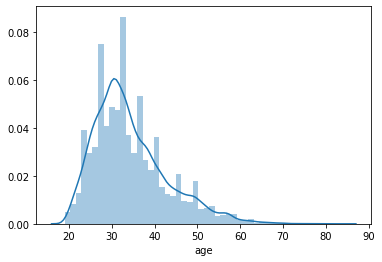

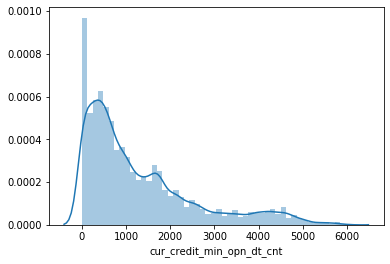

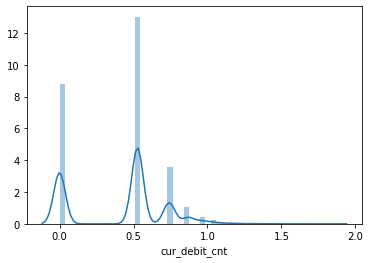

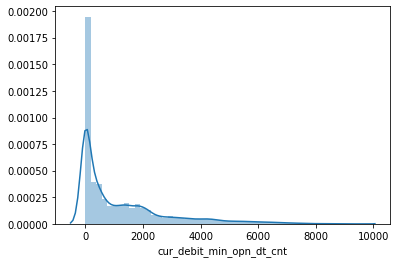

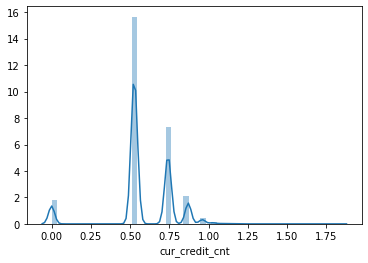

In [870]:
## 观察int类型数据分布
wrong_draw_list=[]
#feature_list=list(train_df.columns.values)
for each in normal_int_list:
    try:
        sns.distplot(train_df[each])
        plt.show()
    except Exception as e:
        print('绘制%s的分布图出错'%each)
        wrong_draw_list.append(each)
        continue

## 4、处理数据

In [616]:
wrong_draw_list

[]

In [617]:
for col in wrong_draw_list:
    train_df[col].hist()
    plt.show()

### df. log('cur_credit_cnt','cur_debit_cnt',2);+ 'edu_deg_cd_null', 'deg_cd_null','atdd_type_null'

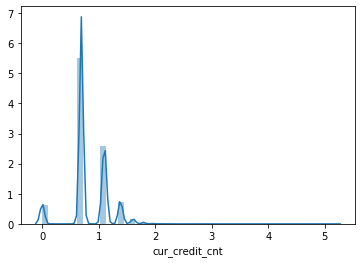

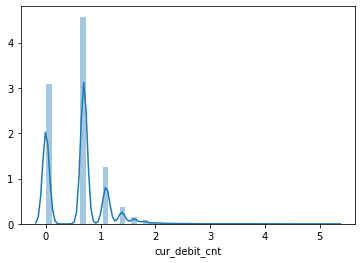

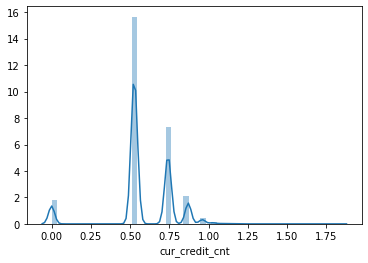

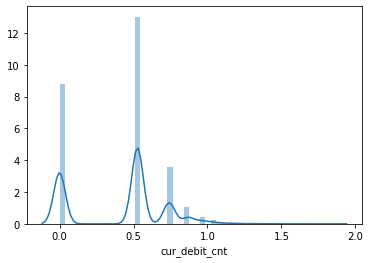

In [618]:
## 对highly skewed的特征两次log处理
# log_list=['cur_credit_cnt','cur_debit_cnt']
# for _ in range(2):
#     for i in log_list:
#         train_df[i] = np.log(1+train_df[i].values)
#         sns.distplot(train_df[i])
#         plt.show()

### df1. del \N;del 1 nan----df1.\N不处理;fillna 1 nan

In [619]:
train_df1=train_df.copy()
# #处理仅一条nan的列,用数量最多的“G”填充
# train_df1['acdm_deg_cd'].fillna('G',inplace=True)

### df2.to_num and /N to mean;one_hot

In [780]:
train_df2=train_df1.copy()
#to_num and mean
#object_to_num=['his_lng_ovd_day','ovd_30d_loan_tot_cnt','l12_mon_gld_buy_whl_tms','l12_mon_insu_buy_whl_tms','l12_mon_fnd_buy_whl_tms','l12mon_buy_fin_mng_whl_tms','job_year','frs_agn_dt_cnt']
for i in object_to_num:
    #i_df=train_df2[i]
    train_df2[i][train_df2[i]!=r'\N']=train_df2[i][train_df2[i]!=r'\N'].map(lambda x :int(x))
    train_df2[i][train_df2[i]==r'\N']=train_df2[i][train_df2[i]!=r'\N'].mean()
    train_df2[i]=train_df2[i].map(lambda x :float(x))
    #i_df=pd.DataFrame(i_df,dtype=np.float)

D:\set_up\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\set_up\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [781]:
# #删掉带r'\N'的记录 #该步骤作废
# for i in list(train_df2.columns.values):
#     train_df2=train_df2[~train_df2[i].isin([r'\N'])]
# (train_df1==r'\N').all()

In [782]:
train_df21=train_df2[['flag']+object_to_num+train_int_list]

In [783]:
#One-Hot：
import category_encoders as ce
can_not_hot=[]
# train_df22=train_df2[['id',object_to_onehot[0]]].merge(train_df21,on='id',how='left')
# train_df22.set_index('id',inplace=True)
train_df22=pd.concat((train_df21,train_df2[[object_to_onehot[0]]]),axis=1)
encoder = ce.OneHotEncoder(cols=object_to_onehot[0]).fit(train_df22)
numeric_dataset_all = encoder.transform(train_df22)# 转换后的数据
for obj in object_to_onehot[1:]:
#     try:
#     obj_df=train_df2[['id',obj]]
#     obj_df.set_index('id',inplace=True)
    obj_df=train_df2[obj]
    encoder = ce.OneHotEncoder(cols=[obj]).fit(obj_df)
    numeric_dataset = encoder.transform(obj_df)# 转换后的数据
    #print('numeric_dataset',numeric_dataset.columns.values)
    #numeric_dataset_all.merge(numeric_dataset,how='outer')
    numeric_dataset_all=pd.concat((numeric_dataset_all,numeric_dataset),axis=1)
    #deled_list.remove(obj)
    #pd.merge(numeric_dataset_all,numeric_dataset,on=['id']+deled_list,how='left')
    #print(obj,numeric_dataset_all.columns.values)
    #print('\n')
numeric_dataset_all.reset_index(inplace=True)
print('sucess!')
#     except Exception as e:
#         can_not_hot.append(obj)
#         continue

sucess!


In [784]:
numeric_dataset_all.rename({'index':'id'},axis=1,inplace=True)

In [786]:
numeric_dataset_all['flag']=numeric_dataset_all['flag'].fillna(2)

In [787]:
test_df1=numeric_dataset_all[numeric_dataset_all['flag']==2]
test_df1.drop('flag',axis=1,inplace=True)
train_df3=numeric_dataset_all[numeric_dataset_all['flag']!=2]

D:\set_up\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [657]:
# train_df3.to_csv('b_train2.csv')
# test_df1.to_csv('b_test2.csv')

## 5、xgboost模型

### 5.1 模型

In [876]:
# train_df3=pd.read_csv('b_train2.csv')
# train_df3.drop('Unnamed: 0',axis=1,inplace=True)
# test_df1=pd.read_csv('b_test2.csv')
# test_df1.drop('Unnamed: 0',axis=1,inplace=True)
train_y = train_df3['flag']
train_X = train_df3.drop(['flag','id'],axis=1,inplace=False)
test_X = test_df1.drop(['id'],axis=1,inplace=False)
skf = model_selection.StratifiedKFold(n_splits=5,random_state=996,shuffle=True)
params=(0.04, 7, 0.9, 0.3)
# params=(0.05, 10, 0.9, 0.3)
# params=(0.03, 10, 0.9, 0.9)
xgb_params = {
'eta':params[0],
'max_depth':params[1],
'sub_sample':params[2],
'colsample_bytree':params[3],
'objective':'binary:logistic',
'eval_metric':'auc',
'silent':0,
# 'learning_rate':0.1,
# 'n_estimators':166,
# 'booster':'gbtree',
# 'n_jobs':4,
# 'gamma':3,
# 'min_child_weight':10,
# 'subsample':0.9,
# 'colsample_bytree':0.3,
# 'seed':7
}

# xgb1 = XGBClassifier(max_depth=5,
#                      eta=0.04,
#                      learning_rate=0.1,
#                      n_estimators=166,
#                      silent=False,
#                      objective='binary:logistic',
#                      booster='gbtree',
#                      n_jobs=4,
#                      gamma=3,
#                      min_child_weight=10,
#                      subsample=0.9,
#                      colsample_bytree=0.3,
#                      seed=7)


print('train_X:')
print(train_X.shape)
print(train_X.columns)
print(len(train_X.columns))
print('\ntest_X:')
print(test_X.shape)
print(test_X.columns)
print(len(test_X.columns))

train_X:
(39923, 257)
Index(['his_lng_ovd_day', 'ovd_30d_loan_tot_cnt', 'l12_mon_gld_buy_whl_tms',
       'l12_mon_insu_buy_whl_tms', 'l12_mon_fnd_buy_whl_tms',
       'l12mon_buy_fin_mng_whl_tms', 'job_year', 'frs_agn_dt_cnt', 'age',
       'cur_credit_min_opn_dt_cnt',
       ...
       'page_no_14', 'page_no_15', 'page_no_16', 'page_no_17', 'page_no_18',
       'page_no_19', 'page_no_20', 'page_no_21', 'page_no_22', 'page_no_23'],
      dtype='object', length=257)
257

test_X:
(4000, 257)
Index(['his_lng_ovd_day', 'ovd_30d_loan_tot_cnt', 'l12_mon_gld_buy_whl_tms',
       'l12_mon_insu_buy_whl_tms', 'l12_mon_fnd_buy_whl_tms',
       'l12mon_buy_fin_mng_whl_tms', 'job_year', 'frs_agn_dt_cnt', 'age',
       'cur_credit_min_opn_dt_cnt',
       ...
       'page_no_14', 'page_no_15', 'page_no_16', 'page_no_17', 'page_no_18',
       'page_no_19', 'page_no_20', 'page_no_21', 'page_no_22', 'page_no_23'],
      dtype='object', length=257)
257


In [877]:
best_iteration =[]
best_score= []
training_score = []
for train_ind,val_ind in skf.split(train_X,train_y):
    X_train,X_val = train_X.iloc[train_ind,],train_X.iloc[val_ind,]
    y_train,y_val = train_y.iloc[train_ind],train_y.iloc[val_ind]
    #print (set(train_y))
    #print (max(train_ind),min(train_ind),max(val_ind),min(val_ind))
    #print (train_ind,val_ind)
    #print(set(y_train))
    dtrain = xgb.DMatrix(X_train,y_train,feature_names = X_train.columns)
    dval = xgb.DMatrix(X_val,y_val,feature_names = X_val.columns)
    model = xgb.train(xgb_params,dtrain,num_boost_round=1000,
                      evals=[(dtrain,'train'),(dval,'val')],verbose_eval=True,early_stopping_rounds=30)
    best_iteration.append(model.attributes()['best_iteration'])
    best_score.append(model.attributes()['best_score'])
    # training_score.append(model.attributes()['best_msg'].split()[1][-8:])
    
#     xgb.plot_importance(model)
#     plt.show()
#     features_importance = model.get_fscore()

    #pd.Series(features_importance).sort_values(ascending=False)
#     print('features_importance',features_importance)
#     a1=open('features_importance1.txt','a')
#     a1.write(str(features_importance))
#     a1.write('***************************************\n')
#     a1.close()
#     print('\n')
#     feature_importance_list = list(dict(sorted(features_importance.items(), key=lambda d: d[1], reverse=True)).keys())
#     print('feature_importance_list',feature_importance_list)

[16:35:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64741	val-auc:0.62525
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.66940	val-auc:0.64046
[2]	train-auc:0.70030	val-auc:0.66465
[3]	train-auc:0.70803	val-auc:0.67123
[4]	train-auc:0.72157	val-auc:0.68312
[5]	train-auc:0.72818	val-auc:0.68656
[6]	train-auc:0.73318	val-auc:0.69214
[7]	train-auc:0.73441	val-auc:0.69115
[8]	train-auc:0.73558	val-auc:0.69257
[9]	train-auc:0.73431	val-auc:0.69190
[10]	train-auc:0.73670	val-auc:0.69451
[11]	train-auc:0.73815	val-auc:0.69376
[12]	tr

[195]	train-auc:0.82556	val-auc:0.71185
[196]	train-auc:0.82617	val-auc:0.71180
[197]	train-auc:0.82621	val-auc:0.71179
[198]	train-auc:0.82657	val-auc:0.71181
[199]	train-auc:0.82667	val-auc:0.71178
[200]	train-auc:0.82671	val-auc:0.71177
[201]	train-auc:0.82683	val-auc:0.71181
[202]	train-auc:0.82711	val-auc:0.71192
Stopping. Best iteration:
[172]	train-auc:0.81954	val-auc:0.71202

[16:35:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64384	val-auc:0.63467
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.66526	val-auc:0.65593
[2

[185]	train-auc:0.82018	val-auc:0.71637
[186]	train-auc:0.82060	val-auc:0.71649
[187]	train-auc:0.82136	val-auc:0.71642
[188]	train-auc:0.82161	val-auc:0.71641
[189]	train-auc:0.82193	val-auc:0.71643
[190]	train-auc:0.82238	val-auc:0.71650
[191]	train-auc:0.82253	val-auc:0.71661
[192]	train-auc:0.82260	val-auc:0.71656
[193]	train-auc:0.82280	val-auc:0.71663
[194]	train-auc:0.82330	val-auc:0.71684
[195]	train-auc:0.82343	val-auc:0.71680
[196]	train-auc:0.82363	val-auc:0.71679
[197]	train-auc:0.82367	val-auc:0.71676
[198]	train-auc:0.82414	val-auc:0.71680
[199]	train-auc:0.82427	val-auc:0.71677
[200]	train-auc:0.82431	val-auc:0.71678
[201]	train-auc:0.82469	val-auc:0.71667
[202]	train-auc:0.82512	val-auc:0.71669
[203]	train-auc:0.82527	val-auc:0.71667
[204]	train-auc:0.82573	val-auc:0.71656
[205]	train-auc:0.82594	val-auc:0.71658
[206]	train-auc:0.82598	val-auc:0.71661
[207]	train-auc:0.82613	val-auc:0.71661
[208]	train-auc:0.82647	val-auc:0.71658
[209]	train-auc:0.82673	val-auc:0.71665


[107]	train-auc:0.79331	val-auc:0.71299
[108]	train-auc:0.79370	val-auc:0.71315
[109]	train-auc:0.79417	val-auc:0.71343
[110]	train-auc:0.79501	val-auc:0.71331
[111]	train-auc:0.79539	val-auc:0.71338
[112]	train-auc:0.79590	val-auc:0.71327
[113]	train-auc:0.79622	val-auc:0.71328
[114]	train-auc:0.79666	val-auc:0.71337
[115]	train-auc:0.79713	val-auc:0.71354
[116]	train-auc:0.79717	val-auc:0.71375
[117]	train-auc:0.79790	val-auc:0.71390
[118]	train-auc:0.79799	val-auc:0.71392
[119]	train-auc:0.79835	val-auc:0.71393
[120]	train-auc:0.79903	val-auc:0.71404
[121]	train-auc:0.79944	val-auc:0.71417
[122]	train-auc:0.79979	val-auc:0.71416
[123]	train-auc:0.80008	val-auc:0.71417
[124]	train-auc:0.80088	val-auc:0.71449
[125]	train-auc:0.80129	val-auc:0.71456
[126]	train-auc:0.80164	val-auc:0.71463
[127]	train-auc:0.80183	val-auc:0.71467
[128]	train-auc:0.80211	val-auc:0.71460
[129]	train-auc:0.80229	val-auc:0.71464
[130]	train-auc:0.80255	val-auc:0.71465
[131]	train-auc:0.80277	val-auc:0.71465


[312]	train-auc:0.83787	val-auc:0.71724
[313]	train-auc:0.83815	val-auc:0.71718
[314]	train-auc:0.83818	val-auc:0.71719
[315]	train-auc:0.83829	val-auc:0.71715
[316]	train-auc:0.83836	val-auc:0.71712
[317]	train-auc:0.83844	val-auc:0.71716
[318]	train-auc:0.83857	val-auc:0.71713
[319]	train-auc:0.83887	val-auc:0.71727
[320]	train-auc:0.83893	val-auc:0.71730
[321]	train-auc:0.83906	val-auc:0.71725
[322]	train-auc:0.83930	val-auc:0.71726
[323]	train-auc:0.83947	val-auc:0.71725
[324]	train-auc:0.83979	val-auc:0.71718
[325]	train-auc:0.83981	val-auc:0.71720
[326]	train-auc:0.83983	val-auc:0.71719
[327]	train-auc:0.83984	val-auc:0.71718
[328]	train-auc:0.83986	val-auc:0.71719
[329]	train-auc:0.84010	val-auc:0.71714
[330]	train-auc:0.84012	val-auc:0.71713
[331]	train-auc:0.84032	val-auc:0.71716
[332]	train-auc:0.84049	val-auc:0.71717
[333]	train-auc:0.84060	val-auc:0.71716
[334]	train-auc:0.84062	val-auc:0.71717
[335]	train-auc:0.84075	val-auc:0.71717
[336]	train-auc:0.84094	val-auc:0.71720


[154]	train-auc:0.80915	val-auc:0.72509
[155]	train-auc:0.80957	val-auc:0.72497
[156]	train-auc:0.80984	val-auc:0.72501
[157]	train-auc:0.81008	val-auc:0.72495
[158]	train-auc:0.81019	val-auc:0.72497
[159]	train-auc:0.81030	val-auc:0.72507
[160]	train-auc:0.81046	val-auc:0.72503
[161]	train-auc:0.81109	val-auc:0.72492
[162]	train-auc:0.81126	val-auc:0.72494
[163]	train-auc:0.81136	val-auc:0.72494
[164]	train-auc:0.81161	val-auc:0.72498
[165]	train-auc:0.81206	val-auc:0.72503
[166]	train-auc:0.81253	val-auc:0.72501
[167]	train-auc:0.81275	val-auc:0.72508
[168]	train-auc:0.81308	val-auc:0.72510
[169]	train-auc:0.81323	val-auc:0.72514
[170]	train-auc:0.81342	val-auc:0.72509
[171]	train-auc:0.81359	val-auc:0.72509
[172]	train-auc:0.81377	val-auc:0.72502
Stopping. Best iteration:
[142]	train-auc:0.80634	val-auc:0.72537

[16:37:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not b

[174]	train-auc:0.81692	val-auc:0.72989
[175]	train-auc:0.81712	val-auc:0.72985
[176]	train-auc:0.81736	val-auc:0.72996
[177]	train-auc:0.81740	val-auc:0.72996
[178]	train-auc:0.81761	val-auc:0.73001
[179]	train-auc:0.81776	val-auc:0.73004
[180]	train-auc:0.81795	val-auc:0.73000
[181]	train-auc:0.81818	val-auc:0.72994
[182]	train-auc:0.81869	val-auc:0.72994
[183]	train-auc:0.81881	val-auc:0.72993
[184]	train-auc:0.81890	val-auc:0.72992
[185]	train-auc:0.81920	val-auc:0.72996
[186]	train-auc:0.81931	val-auc:0.72994
[187]	train-auc:0.81973	val-auc:0.72994
[188]	train-auc:0.81998	val-auc:0.72984
[189]	train-auc:0.82017	val-auc:0.72980
[190]	train-auc:0.82054	val-auc:0.72977
[191]	train-auc:0.82064	val-auc:0.72979
[192]	train-auc:0.82081	val-auc:0.72981
[193]	train-auc:0.82090	val-auc:0.72990
[194]	train-auc:0.82106	val-auc:0.72990
[195]	train-auc:0.82126	val-auc:0.72991
[196]	train-auc:0.82164	val-auc:0.72987
[197]	train-auc:0.82175	val-auc:0.72988
[198]	train-auc:0.82196	val-auc:0.72987


In [878]:
#val-auc.mean
np.array(best_score).astype(float).mean()

0.7203412

In [675]:
i5=pd.Series(features_importance).sort_values(ascending=False)
im2_4=i5

cur_credit_min_opn_dt_cnt        4789
age                              3266
cur_debit_min_opn_dt_cnt         3039
job_year                         1708
frs_agn_dt_cnt                   1520
                                 ... 
Trx_Cod2_Cd_25                      1
l6mon_agn_ind_3                     1
fin_rsk_ases_grd_cd_8               1
confirm_rsk_ases_lvl_typ_cd_9       1
edu_deg_cd_12                       1
Length: 174, dtype: int64

In [728]:
val_auc_mean=best_im(num=8)

[10:52:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.72208	val-auc:0.67592
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.73413	val-auc:0.68817
[2]	train-auc:0.75670	val-auc:0.70056
[3]	train-auc:0.76729	val-auc:0.70242
[4]	train-auc:0.77498	val-auc:0.70512
[5]	train-auc:0.78242	val-auc:0.71007
[6]	train-auc:0.78191	val-auc:0.70955
[7]	train-auc:0.78812	val-auc:0.71208
[8]	train-auc:0.78989	val-auc:0.71181
[9]	train-auc:0.79235	val-auc:0.71377
[10]	train-auc:0.79250	val-auc:0.71427
[11]	train-auc:0.79315	val-auc:0.71447
[12]	tr

[30]	train-auc:0.82499	val-auc:0.69737
[31]	train-auc:0.82854	val-auc:0.69848
[32]	train-auc:0.82988	val-auc:0.69853
[33]	train-auc:0.83134	val-auc:0.69866
[34]	train-auc:0.83172	val-auc:0.69870
[35]	train-auc:0.83257	val-auc:0.69826
[36]	train-auc:0.83354	val-auc:0.69844
[37]	train-auc:0.83334	val-auc:0.69870
[38]	train-auc:0.83519	val-auc:0.69915
[39]	train-auc:0.83623	val-auc:0.69917
[40]	train-auc:0.83849	val-auc:0.69990
[41]	train-auc:0.83912	val-auc:0.70042
[42]	train-auc:0.83955	val-auc:0.70062
[43]	train-auc:0.84092	val-auc:0.70029
[44]	train-auc:0.84194	val-auc:0.70015
[45]	train-auc:0.84342	val-auc:0.70061
[46]	train-auc:0.84349	val-auc:0.70036
[47]	train-auc:0.84434	val-auc:0.70084
[48]	train-auc:0.84599	val-auc:0.70110
[49]	train-auc:0.84694	val-auc:0.70141
[50]	train-auc:0.84947	val-auc:0.70187
[51]	train-auc:0.85039	val-auc:0.70199
[52]	train-auc:0.85195	val-auc:0.70190
[53]	train-auc:0.85434	val-auc:0.70239
[54]	train-auc:0.85459	val-auc:0.70235
[55]	train-auc:0.85620	va

[91]	train-auc:0.88213	val-auc:0.71466
[92]	train-auc:0.88236	val-auc:0.71489
[93]	train-auc:0.88314	val-auc:0.71515
[94]	train-auc:0.88397	val-auc:0.71544
[95]	train-auc:0.88435	val-auc:0.71554
[96]	train-auc:0.88476	val-auc:0.71543
[97]	train-auc:0.88493	val-auc:0.71541
[98]	train-auc:0.88580	val-auc:0.71548
[99]	train-auc:0.88676	val-auc:0.71530
[100]	train-auc:0.88782	val-auc:0.71501
[101]	train-auc:0.88895	val-auc:0.71511
[102]	train-auc:0.88924	val-auc:0.71510
[103]	train-auc:0.88966	val-auc:0.71515
[104]	train-auc:0.88983	val-auc:0.71501
[105]	train-auc:0.88999	val-auc:0.71503
[106]	train-auc:0.89040	val-auc:0.71509
[107]	train-auc:0.89169	val-auc:0.71535
[108]	train-auc:0.89183	val-auc:0.71526
[109]	train-auc:0.89316	val-auc:0.71537
[110]	train-auc:0.89329	val-auc:0.71525
[111]	train-auc:0.89362	val-auc:0.71532
[112]	train-auc:0.89386	val-auc:0.71522
[113]	train-auc:0.89432	val-auc:0.71500
[114]	train-auc:0.89452	val-auc:0.71501
[115]	train-auc:0.89520	val-auc:0.71497
[116]	tra

[16]	train-auc:0.81217	val-auc:0.70031
[17]	train-auc:0.81265	val-auc:0.70092
[18]	train-auc:0.81320	val-auc:0.70046
[19]	train-auc:0.81744	val-auc:0.70155
[20]	train-auc:0.81801	val-auc:0.70121
[21]	train-auc:0.81984	val-auc:0.70165
[22]	train-auc:0.82047	val-auc:0.70116
[23]	train-auc:0.82136	val-auc:0.70144
[24]	train-auc:0.82188	val-auc:0.70118
[25]	train-auc:0.82368	val-auc:0.70102
[26]	train-auc:0.82459	val-auc:0.70102
[27]	train-auc:0.82439	val-auc:0.70130
[28]	train-auc:0.82528	val-auc:0.70142
[29]	train-auc:0.82725	val-auc:0.70163
[30]	train-auc:0.82824	val-auc:0.70205
[31]	train-auc:0.83139	val-auc:0.70278
[32]	train-auc:0.83211	val-auc:0.70303
[33]	train-auc:0.83399	val-auc:0.70367
[34]	train-auc:0.83446	val-auc:0.70368
[35]	train-auc:0.83518	val-auc:0.70338
[36]	train-auc:0.83560	val-auc:0.70346
[37]	train-auc:0.83537	val-auc:0.70356
[38]	train-auc:0.83678	val-auc:0.70370
[39]	train-auc:0.83792	val-auc:0.70404
[40]	train-auc:0.84038	val-auc:0.70526
[41]	train-auc:0.84141	va

In [729]:
val_auc_mean

{'train-auc': {6: 0.893328}, 'val-auc': {6: 0.717015}}

### 5.2 筛选特征
用im>=num来筛选变量，最终找出最大val_auc对应的num

In [681]:
def best_im(num,im2_4=im2_4,each_param=[0.05,10,0.9,0.3],train_df3=train_df3):
#     train_df3=pd.read_csv('train_df_handled.csv')
#     train_df3.drop(columns='Unnamed: 0',inplace=True)
#     test_df1=pd.read_csv('test_df_handled.csv')
#     test_df1.drop(columns='Unnamed: 0',inplace=True)
    im_2_more_list=list(im2_4[im2_4.values>=num].index.values)
    # train_df3=numeric_dataset_all.copy()
    #直接进入xgb实验
    # train_df3.reset_index(inplace=True)
    train_y = train_df3['flag']
    #'RevolvingUtilizationOfUnsecuredLines'
    train_X = train_df3.drop(['flag','id'],axis=1,inplace=False)
    train_X=train_X[im_2_more_list]
#     test_X = test_df1.drop(['id'],axis=1,inplace=False)
    skf = model_selection.StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
    xgb_params = {
    'eta':each_param[0],
    'max_depth':each_param[1],
    'sub_sample':each_param[2],
    'colsample_bytree':each_param[3],
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'silent':0
    }
    best_score= []
    training_score = []
    train_performance ={} 
    val_performance={}
    for train_ind,val_ind in skf.split(train_X,train_y):
        X_train,X_val = train_X.iloc[train_ind,],train_X.iloc[val_ind,]
        y_train,y_val = train_y.iloc[train_ind],train_y.iloc[val_ind]
        dtrain = xgb.DMatrix(X_train,y_train,feature_names = X_train.columns)
        dval = xgb.DMatrix(X_val,y_val,feature_names = X_val.columns)
        model = xgb.train(xgb_params,dtrain,num_boost_round=1000,
                          evals=[(dtrain,'train'),(dval,'val')],verbose_eval=True,early_stopping_rounds=30)
        best_score.append(model.attributes()['best_score'])
        training_score.append(model.attributes()['best_msg'].split()[1][10:])
    valid_mean = (np.asarray(best_score).astype(np.float).mean()) # mean AUC in valid set
    train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
    val_performance[num] =  valid_mean
    train_performance[num] =  train_mean
    auc_dict={'train-auc':train_performance,'val-auc':val_performance}
    print(auc_dict)
    return auc_dict

In [693]:
#耗时
val_auc_dict={}
for i in range(6):
#     val_auc_mean=best_im(num=i,each_param=list(train_val_mean_max_param[3]))
    val_auc_mean=best_im(num=i)

# a=open('auc.txt','a')
# a.write(str(auc_dict))
# a.close()
    val_auc_dict[i]=val_auc_mean
    print(val_auc_dict)

[10:05:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.70983	val-auc:0.64310
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.72443	val-auc:0.66409
[2]	train-auc:0.74281	val-auc:0.67670
[3]	train-auc:0.76083	val-auc:0.68589
[4]	train-auc:0.76725	val-auc:0.68960
[5]	train-auc:0.77655	val-auc:0.69809
[6]	train-auc:0.77530	val-auc:0.69841
[7]	train-auc:0.78599	val-auc:0.70425
[8]	train-auc:0.78861	val-auc:0.70531
[9]	train-auc:0.79202	val-auc:0.70836
[10]	train-auc:0.79250	val-auc:0.70981
[11]	train-auc:0.79349	val-auc:0.71071
[12]	tr

[30]	train-auc:0.82754	val-auc:0.69829
[31]	train-auc:0.83117	val-auc:0.69942
[32]	train-auc:0.83304	val-auc:0.69972
[33]	train-auc:0.83313	val-auc:0.70011
[34]	train-auc:0.83365	val-auc:0.70038
[35]	train-auc:0.83526	val-auc:0.70046
[36]	train-auc:0.83565	val-auc:0.70087
[37]	train-auc:0.83560	val-auc:0.70125
[38]	train-auc:0.83687	val-auc:0.70204
[39]	train-auc:0.83698	val-auc:0.70194
[40]	train-auc:0.83932	val-auc:0.70217
[41]	train-auc:0.84110	val-auc:0.70234
[42]	train-auc:0.84115	val-auc:0.70247
[43]	train-auc:0.84284	val-auc:0.70221
[44]	train-auc:0.84406	val-auc:0.70226
[45]	train-auc:0.84500	val-auc:0.70267
[46]	train-auc:0.84553	val-auc:0.70282
[47]	train-auc:0.84666	val-auc:0.70348
[48]	train-auc:0.84848	val-auc:0.70382
[49]	train-auc:0.84980	val-auc:0.70378
[50]	train-auc:0.85056	val-auc:0.70415
[51]	train-auc:0.85115	val-auc:0.70400
[52]	train-auc:0.85223	val-auc:0.70420
[53]	train-auc:0.85452	val-auc:0.70463
[54]	train-auc:0.85450	val-auc:0.70480
[55]	train-auc:0.85579	va

[115]	train-auc:0.89956	val-auc:0.71674
[116]	train-auc:0.89984	val-auc:0.71670
[117]	train-auc:0.90017	val-auc:0.71676
[118]	train-auc:0.90095	val-auc:0.71693
[119]	train-auc:0.90115	val-auc:0.71688
[120]	train-auc:0.90129	val-auc:0.71689
[121]	train-auc:0.90150	val-auc:0.71693
[122]	train-auc:0.90201	val-auc:0.71705
[123]	train-auc:0.90271	val-auc:0.71698
[124]	train-auc:0.90311	val-auc:0.71698
[125]	train-auc:0.90348	val-auc:0.71693
[126]	train-auc:0.90370	val-auc:0.71697
[127]	train-auc:0.90417	val-auc:0.71679
[128]	train-auc:0.90439	val-auc:0.71691
[129]	train-auc:0.90448	val-auc:0.71699
[130]	train-auc:0.90476	val-auc:0.71700
[131]	train-auc:0.90517	val-auc:0.71700
[132]	train-auc:0.90517	val-auc:0.71708
[133]	train-auc:0.90558	val-auc:0.71699
[134]	train-auc:0.90597	val-auc:0.71683
[135]	train-auc:0.90648	val-auc:0.71661
[136]	train-auc:0.90688	val-auc:0.71660
[137]	train-auc:0.90763	val-auc:0.71662
[138]	train-auc:0.90809	val-auc:0.71657
[139]	train-auc:0.90820	val-auc:0.71645


[145]	train-auc:0.91292	val-auc:0.72064
[146]	train-auc:0.91348	val-auc:0.72059
[147]	train-auc:0.91370	val-auc:0.72066
[148]	train-auc:0.91391	val-auc:0.72064
[149]	train-auc:0.91498	val-auc:0.72037
[150]	train-auc:0.91503	val-auc:0.72037
[151]	train-auc:0.91520	val-auc:0.72037
[152]	train-auc:0.91531	val-auc:0.72036
[153]	train-auc:0.91645	val-auc:0.72041
[154]	train-auc:0.91657	val-auc:0.72047
[155]	train-auc:0.91663	val-auc:0.72052
Stopping. Best iteration:
[125]	train-auc:0.90621	val-auc:0.72121

[10:06:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.71765	val-auc:0.64250
Multiple eval metrics have been passed: 'val-auc' will be u

[3]	train-auc:0.76083	val-auc:0.68589
[4]	train-auc:0.76725	val-auc:0.68960
[5]	train-auc:0.77655	val-auc:0.69809
[6]	train-auc:0.77530	val-auc:0.69841
[7]	train-auc:0.78599	val-auc:0.70425
[8]	train-auc:0.78861	val-auc:0.70531
[9]	train-auc:0.79202	val-auc:0.70836
[10]	train-auc:0.79250	val-auc:0.70981
[11]	train-auc:0.79349	val-auc:0.71071
[12]	train-auc:0.79397	val-auc:0.71234
[13]	train-auc:0.80053	val-auc:0.71375
[14]	train-auc:0.80029	val-auc:0.71381
[15]	train-auc:0.80251	val-auc:0.71410
[16]	train-auc:0.80374	val-auc:0.71453
[17]	train-auc:0.80490	val-auc:0.71395
[18]	train-auc:0.80839	val-auc:0.71395
[19]	train-auc:0.81099	val-auc:0.71402
[20]	train-auc:0.81128	val-auc:0.71443
[21]	train-auc:0.81207	val-auc:0.71526
[22]	train-auc:0.81187	val-auc:0.71531
[23]	train-auc:0.81285	val-auc:0.71555
[24]	train-auc:0.81417	val-auc:0.71521
[25]	train-auc:0.81915	val-auc:0.71666
[26]	train-auc:0.81997	val-auc:0.71733
[27]	train-auc:0.81982	val-auc:0.71777
[28]	train-auc:0.82358	val-auc:0

[46]	train-auc:0.84553	val-auc:0.70282
[47]	train-auc:0.84666	val-auc:0.70348
[48]	train-auc:0.84848	val-auc:0.70382
[49]	train-auc:0.84980	val-auc:0.70378
[50]	train-auc:0.85056	val-auc:0.70415
[51]	train-auc:0.85115	val-auc:0.70400
[52]	train-auc:0.85223	val-auc:0.70420
[53]	train-auc:0.85452	val-auc:0.70463
[54]	train-auc:0.85450	val-auc:0.70480
[55]	train-auc:0.85579	val-auc:0.70463
[56]	train-auc:0.85743	val-auc:0.70474
[57]	train-auc:0.85814	val-auc:0.70528
[58]	train-auc:0.85860	val-auc:0.70561
[59]	train-auc:0.85939	val-auc:0.70544
[60]	train-auc:0.86099	val-auc:0.70613
[61]	train-auc:0.86266	val-auc:0.70619
[62]	train-auc:0.86392	val-auc:0.70635
[63]	train-auc:0.86471	val-auc:0.70657
[64]	train-auc:0.86609	val-auc:0.70720
[65]	train-auc:0.86626	val-auc:0.70733
[66]	train-auc:0.86681	val-auc:0.70742
[67]	train-auc:0.86710	val-auc:0.70745
[68]	train-auc:0.86866	val-auc:0.70749
[69]	train-auc:0.86896	val-auc:0.70741
[70]	train-auc:0.87071	val-auc:0.70778
[71]	train-auc:0.87148	va

[130]	train-auc:0.90476	val-auc:0.71700
[131]	train-auc:0.90517	val-auc:0.71700
[132]	train-auc:0.90517	val-auc:0.71708
[133]	train-auc:0.90558	val-auc:0.71699
[134]	train-auc:0.90597	val-auc:0.71683
[135]	train-auc:0.90648	val-auc:0.71661
[136]	train-auc:0.90688	val-auc:0.71660
[137]	train-auc:0.90763	val-auc:0.71662
[138]	train-auc:0.90809	val-auc:0.71657
[139]	train-auc:0.90820	val-auc:0.71645
[140]	train-auc:0.90855	val-auc:0.71646
[141]	train-auc:0.90934	val-auc:0.71669
[142]	train-auc:0.90969	val-auc:0.71676
[143]	train-auc:0.91018	val-auc:0.71674
[144]	train-auc:0.91041	val-auc:0.71671
[145]	train-auc:0.91118	val-auc:0.71674
[146]	train-auc:0.91190	val-auc:0.71673
[147]	train-auc:0.91212	val-auc:0.71656
[148]	train-auc:0.91260	val-auc:0.71678
[149]	train-auc:0.91340	val-auc:0.71670
[150]	train-auc:0.91352	val-auc:0.71680
[151]	train-auc:0.91365	val-auc:0.71684
[152]	train-auc:0.91378	val-auc:0.71679
[153]	train-auc:0.91446	val-auc:0.71683
[154]	train-auc:0.91458	val-auc:0.71682


Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.73130	val-auc:0.65880
[2]	train-auc:0.75058	val-auc:0.66526
[3]	train-auc:0.77093	val-auc:0.67932
[4]	train-auc:0.77670	val-auc:0.68344
[5]	train-auc:0.78241	val-auc:0.69013
[6]	train-auc:0.78173	val-auc:0.69151
[7]	train-auc:0.79136	val-auc:0.69549
[8]	train-auc:0.79293	val-auc:0.69539
[9]	train-auc:0.79789	val-auc:0.69472
[10]	train-auc:0.79765	val-auc:0.69622
[11]	train-auc:0.79829	val-auc:0.69570
[12]	train-auc:0.79879	val-auc:0.69751
[13]	train-auc:0.80366	val-auc:0.69764
[14]	train-auc:0.80444	val-auc:0.69743
[15]	train-auc:0.80632	val-auc:0.69901
[16]	train-auc:0.80734	val-auc:0.69852
[17]	train-auc:0.80837	val-auc:0.69861
[18]	train-auc:0.81093	val-auc:0.69833
[19]	train-auc:0.81487	val-auc:0.69866
[20]	train-auc:0.81477	val-auc:0.69825
[21]	train-auc:0.81541	val-auc:0.69892
[22]	train-auc:0.81515	val-auc:0.69870
[23]	train-a

[25]	train-auc:0.81954	val-auc:0.71789
[26]	train-auc:0.82026	val-auc:0.71849
[27]	train-auc:0.82002	val-auc:0.71872
[28]	train-auc:0.82289	val-auc:0.71824
[29]	train-auc:0.82390	val-auc:0.71822
[30]	train-auc:0.82657	val-auc:0.71808
[31]	train-auc:0.83012	val-auc:0.71917
[32]	train-auc:0.83177	val-auc:0.71910
[33]	train-auc:0.83280	val-auc:0.71939
[34]	train-auc:0.83296	val-auc:0.71932
[35]	train-auc:0.83420	val-auc:0.71954
[36]	train-auc:0.83466	val-auc:0.71975
[37]	train-auc:0.83481	val-auc:0.71997
[38]	train-auc:0.83660	val-auc:0.72034
[39]	train-auc:0.83708	val-auc:0.72057
[40]	train-auc:0.83937	val-auc:0.72102
[41]	train-auc:0.84071	val-auc:0.72072
[42]	train-auc:0.84011	val-auc:0.72101
[43]	train-auc:0.84121	val-auc:0.72087
[44]	train-auc:0.84169	val-auc:0.72081
[45]	train-auc:0.84271	val-auc:0.72102
[46]	train-auc:0.84327	val-auc:0.72128
[47]	train-auc:0.84496	val-auc:0.72140
[48]	train-auc:0.84691	val-auc:0.72209
[49]	train-auc:0.84786	val-auc:0.72237
[50]	train-auc:0.85099	va

[37]	train-auc:0.83596	val-auc:0.70085
[38]	train-auc:0.83773	val-auc:0.70130
[39]	train-auc:0.83805	val-auc:0.70127
[40]	train-auc:0.84018	val-auc:0.70186
[41]	train-auc:0.84214	val-auc:0.70221
[42]	train-auc:0.84204	val-auc:0.70261
[43]	train-auc:0.84363	val-auc:0.70239
[44]	train-auc:0.84461	val-auc:0.70233
[45]	train-auc:0.84594	val-auc:0.70234
[46]	train-auc:0.84627	val-auc:0.70250
[47]	train-auc:0.84783	val-auc:0.70290
[48]	train-auc:0.84961	val-auc:0.70312
[49]	train-auc:0.85068	val-auc:0.70351
[50]	train-auc:0.85318	val-auc:0.70384
[51]	train-auc:0.85395	val-auc:0.70395
[52]	train-auc:0.85533	val-auc:0.70408
[53]	train-auc:0.85745	val-auc:0.70465
[54]	train-auc:0.85748	val-auc:0.70467
[55]	train-auc:0.85865	val-auc:0.70471
[56]	train-auc:0.86037	val-auc:0.70486
[57]	train-auc:0.86142	val-auc:0.70474
[58]	train-auc:0.86162	val-auc:0.70510
[59]	train-auc:0.86214	val-auc:0.70516
[60]	train-auc:0.86327	val-auc:0.70539
[61]	train-auc:0.86477	val-auc:0.70542
[62]	train-auc:0.86572	va

[95]	train-auc:0.89070	val-auc:0.71628
[96]	train-auc:0.89193	val-auc:0.71637
[97]	train-auc:0.89216	val-auc:0.71634
[98]	train-auc:0.89272	val-auc:0.71633
[99]	train-auc:0.89321	val-auc:0.71640
[100]	train-auc:0.89405	val-auc:0.71630
[101]	train-auc:0.89511	val-auc:0.71653
[102]	train-auc:0.89526	val-auc:0.71652
[103]	train-auc:0.89563	val-auc:0.71630
[104]	train-auc:0.89568	val-auc:0.71650
[105]	train-auc:0.89584	val-auc:0.71645
[106]	train-auc:0.89644	val-auc:0.71656
[107]	train-auc:0.89673	val-auc:0.71669
[108]	train-auc:0.89687	val-auc:0.71655
[109]	train-auc:0.89782	val-auc:0.71649
[110]	train-auc:0.89803	val-auc:0.71644
[111]	train-auc:0.89808	val-auc:0.71646
[112]	train-auc:0.89822	val-auc:0.71636
[113]	train-auc:0.89843	val-auc:0.71652
[114]	train-auc:0.89864	val-auc:0.71670
[115]	train-auc:0.89955	val-auc:0.71679
[116]	train-auc:0.89975	val-auc:0.71682
[117]	train-auc:0.90006	val-auc:0.71694
Stopping. Best iteration:
[87]	train-auc:0.88593	val-auc:0.71717

[10:09:53] WARNING:

[170]	train-auc:0.91814	val-auc:0.72091
[171]	train-auc:0.91900	val-auc:0.72078
[172]	train-auc:0.91930	val-auc:0.72067
[173]	train-auc:0.91943	val-auc:0.72062
[174]	train-auc:0.91975	val-auc:0.72040
[175]	train-auc:0.91989	val-auc:0.72040
[176]	train-auc:0.92018	val-auc:0.72041
[177]	train-auc:0.92028	val-auc:0.72027
[178]	train-auc:0.92063	val-auc:0.72021
Stopping. Best iteration:
[148]	train-auc:0.91247	val-auc:0.72128

[10:10:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.71365	val-auc:0.64860
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.


Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.73573	val-auc:0.68561
[2]	train-auc:0.74722	val-auc:0.69292
[3]	train-auc:0.76180	val-auc:0.69673
[4]	train-auc:0.76799	val-auc:0.69826
[5]	train-auc:0.77769	val-auc:0.70483
[6]	train-auc:0.77740	val-auc:0.70560
[7]	train-auc:0.78395	val-auc:0.71003
[8]	train-auc:0.78652	val-auc:0.71027
[9]	train-auc:0.78976	val-auc:0.71212
[10]	train-auc:0.79026	val-auc:0.71316
[11]	train-auc:0.79147	val-auc:0.71401
[12]	train-auc:0.79226	val-auc:0.71513
[13]	train-auc:0.79900	val-auc:0.71670
[14]	train-auc:0.79947	val-auc:0.71691
[15]	train-auc:0.80209	val-auc:0.71677
[16]	train-auc:0.80337	val-auc:0.71687
[17]	train-auc:0.80410	val-auc:0.71718
[18]	train-auc:0.80736	val-auc:0.71676
[19]	train-auc:0.80924	val-auc:0.71656
[20]	train-auc:0.80864	val-auc:0.71661
[21]	train-auc:0.81072	val-auc:0.71683
[22]	train-auc:0.81030	val-auc:0.71686
[23]	train-a

[8]	train-auc:0.78885	val-auc:0.69050
[9]	train-auc:0.79339	val-auc:0.69297
[10]	train-auc:0.79419	val-auc:0.69357
[11]	train-auc:0.79532	val-auc:0.69355
[12]	train-auc:0.79653	val-auc:0.69340
[13]	train-auc:0.80251	val-auc:0.69550
[14]	train-auc:0.80429	val-auc:0.69499
[15]	train-auc:0.80653	val-auc:0.69592
[16]	train-auc:0.80733	val-auc:0.69648
[17]	train-auc:0.80788	val-auc:0.69642
[18]	train-auc:0.80977	val-auc:0.69654
[19]	train-auc:0.81193	val-auc:0.69639
[20]	train-auc:0.81107	val-auc:0.69637
[21]	train-auc:0.81176	val-auc:0.69659
[22]	train-auc:0.81149	val-auc:0.69658
[23]	train-auc:0.81271	val-auc:0.69631
[24]	train-auc:0.81432	val-auc:0.69659
[25]	train-auc:0.81816	val-auc:0.69744
[26]	train-auc:0.81885	val-auc:0.69783
[27]	train-auc:0.81889	val-auc:0.69847
[28]	train-auc:0.81979	val-auc:0.69849
[29]	train-auc:0.82139	val-auc:0.69864
[30]	train-auc:0.82351	val-auc:0.69759
[31]	train-auc:0.82693	val-auc:0.69847
[32]	train-auc:0.82870	val-auc:0.69869
[33]	train-auc:0.82994	val-

[88]	train-auc:0.88336	val-auc:0.71512
[89]	train-auc:0.88434	val-auc:0.71513
[90]	train-auc:0.88437	val-auc:0.71526
[91]	train-auc:0.88482	val-auc:0.71524
[92]	train-auc:0.88504	val-auc:0.71530
[93]	train-auc:0.88581	val-auc:0.71541
[94]	train-auc:0.88645	val-auc:0.71546
[95]	train-auc:0.88684	val-auc:0.71554
[96]	train-auc:0.88740	val-auc:0.71567
[97]	train-auc:0.88749	val-auc:0.71583
[98]	train-auc:0.88838	val-auc:0.71585
[99]	train-auc:0.88888	val-auc:0.71601
[100]	train-auc:0.88983	val-auc:0.71572
[101]	train-auc:0.89087	val-auc:0.71560
[102]	train-auc:0.89098	val-auc:0.71557
[103]	train-auc:0.89131	val-auc:0.71552
[104]	train-auc:0.89143	val-auc:0.71555
[105]	train-auc:0.89156	val-auc:0.71560
[106]	train-auc:0.89203	val-auc:0.71565
[107]	train-auc:0.89231	val-auc:0.71574
[108]	train-auc:0.89250	val-auc:0.71565
[109]	train-auc:0.89388	val-auc:0.71582
[110]	train-auc:0.89403	val-auc:0.71584
[111]	train-auc:0.89419	val-auc:0.71583
[112]	train-auc:0.89437	val-auc:0.71588
[113]	train-

[65]	train-auc:0.86647	val-auc:0.71758
[66]	train-auc:0.86695	val-auc:0.71754
[67]	train-auc:0.86728	val-auc:0.71772
[68]	train-auc:0.86921	val-auc:0.71799
[69]	train-auc:0.86969	val-auc:0.71793
[70]	train-auc:0.87143	val-auc:0.71818
[71]	train-auc:0.87165	val-auc:0.71821
[72]	train-auc:0.87179	val-auc:0.71850
[73]	train-auc:0.87239	val-auc:0.71864
[74]	train-auc:0.87276	val-auc:0.71857
[75]	train-auc:0.87329	val-auc:0.71872
[76]	train-auc:0.87340	val-auc:0.71893
[77]	train-auc:0.87408	val-auc:0.71887
[78]	train-auc:0.87436	val-auc:0.71900
[79]	train-auc:0.87581	val-auc:0.71927
[80]	train-auc:0.87833	val-auc:0.71878
[81]	train-auc:0.87914	val-auc:0.71855
[82]	train-auc:0.88001	val-auc:0.71892
[83]	train-auc:0.88068	val-auc:0.71867
[84]	train-auc:0.88168	val-auc:0.71875
[85]	train-auc:0.88310	val-auc:0.71906
[86]	train-auc:0.88414	val-auc:0.71966
[87]	train-auc:0.88497	val-auc:0.71947
[88]	train-auc:0.88511	val-auc:0.71951
[89]	train-auc:0.88620	val-auc:0.71929
[90]	train-auc:0.88636	va

[120]	train-auc:0.89810	val-auc:0.71399
[121]	train-auc:0.89828	val-auc:0.71395
[122]	train-auc:0.89889	val-auc:0.71387
[123]	train-auc:0.89990	val-auc:0.71392
[124]	train-auc:0.90034	val-auc:0.71435
[125]	train-auc:0.90076	val-auc:0.71449
[126]	train-auc:0.90079	val-auc:0.71456
[127]	train-auc:0.90100	val-auc:0.71464
[128]	train-auc:0.90134	val-auc:0.71468
[129]	train-auc:0.90133	val-auc:0.71457
[130]	train-auc:0.90151	val-auc:0.71460
[131]	train-auc:0.90183	val-auc:0.71467
[132]	train-auc:0.90236	val-auc:0.71454
[133]	train-auc:0.90276	val-auc:0.71465
[134]	train-auc:0.90313	val-auc:0.71458
[135]	train-auc:0.90385	val-auc:0.71468
[136]	train-auc:0.90426	val-auc:0.71462
[137]	train-auc:0.90514	val-auc:0.71425
[138]	train-auc:0.90557	val-auc:0.71445
[139]	train-auc:0.90565	val-auc:0.71442
[140]	train-auc:0.90589	val-auc:0.71444
[141]	train-auc:0.90630	val-auc:0.71444
[142]	train-auc:0.90683	val-auc:0.71442
[143]	train-auc:0.90698	val-auc:0.71441
[144]	train-auc:0.90727	val-auc:0.71448


Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.74392	val-auc:0.66629
[2]	train-auc:0.75907	val-auc:0.67733
[3]	train-auc:0.77238	val-auc:0.68141
[4]	train-auc:0.77954	val-auc:0.68623
[5]	train-auc:0.78471	val-auc:0.68620
[6]	train-auc:0.78303	val-auc:0.68607
[7]	train-auc:0.78741	val-auc:0.68811
[8]	train-auc:0.79113	val-auc:0.68909
[9]	train-auc:0.79502	val-auc:0.69124
[10]	train-auc:0.79564	val-auc:0.69326
[11]	train-auc:0.79768	val-auc:0.69330
[12]	train-auc:0.79907	val-auc:0.69329
[13]	train-auc:0.80396	val-auc:0.69587
[14]	train-auc:0.80576	val-auc:0.69533
[15]	train-auc:0.80782	val-auc:0.69554
[16]	train-auc:0.81066	val-auc:0.69578
[17]	train-auc:0.81106	val-auc:0.69542
[18]	train-auc:0.81266	val-auc:0.69549
[19]	train-auc:0.81763	val-auc:0.69636
[20]	train-auc:0.81843	val-auc:0.69625
[21]	train-auc:0.81939	val-auc:0.69671
[22]	train-auc:0.81879	val-auc:0.69672
[23]	train-a

[30]	train-auc:0.82604	val-auc:0.70660
[31]	train-auc:0.82910	val-auc:0.70834
[32]	train-auc:0.83030	val-auc:0.70822
[33]	train-auc:0.83122	val-auc:0.70823
[34]	train-auc:0.83151	val-auc:0.70809
[35]	train-auc:0.83217	val-auc:0.70827
[36]	train-auc:0.83249	val-auc:0.70872
[37]	train-auc:0.83269	val-auc:0.70828
[38]	train-auc:0.83459	val-auc:0.70866
[39]	train-auc:0.83595	val-auc:0.70855
[40]	train-auc:0.83912	val-auc:0.70899
[41]	train-auc:0.84041	val-auc:0.70945
[42]	train-auc:0.84022	val-auc:0.70943
[43]	train-auc:0.84101	val-auc:0.70936
[44]	train-auc:0.84228	val-auc:0.70962
[45]	train-auc:0.84366	val-auc:0.70994
[46]	train-auc:0.84441	val-auc:0.70995
[47]	train-auc:0.84573	val-auc:0.71033
[48]	train-auc:0.84680	val-auc:0.71066
[49]	train-auc:0.84784	val-auc:0.71029
[50]	train-auc:0.85041	val-auc:0.71125
[51]	train-auc:0.85141	val-auc:0.71073
[52]	train-auc:0.85278	val-auc:0.71070
[53]	train-auc:0.85510	val-auc:0.71076
[54]	train-auc:0.85536	val-auc:0.71114
[55]	train-auc:0.85700	va

[51]	train-auc:0.85193	val-auc:0.71688
[52]	train-auc:0.85318	val-auc:0.71675
[53]	train-auc:0.85613	val-auc:0.71705
[54]	train-auc:0.85649	val-auc:0.71712
[55]	train-auc:0.85822	val-auc:0.71662
[56]	train-auc:0.86035	val-auc:0.71648
[57]	train-auc:0.86043	val-auc:0.71658
[58]	train-auc:0.86099	val-auc:0.71713
[59]	train-auc:0.86135	val-auc:0.71723
[60]	train-auc:0.86288	val-auc:0.71780
[61]	train-auc:0.86402	val-auc:0.71795
[62]	train-auc:0.86403	val-auc:0.71808
[63]	train-auc:0.86502	val-auc:0.71842
[64]	train-auc:0.86676	val-auc:0.71865
[65]	train-auc:0.86699	val-auc:0.71873
[66]	train-auc:0.86757	val-auc:0.71874
[67]	train-auc:0.86807	val-auc:0.71893
[68]	train-auc:0.86998	val-auc:0.71908
[69]	train-auc:0.87049	val-auc:0.71933
[70]	train-auc:0.87223	val-auc:0.71957
[71]	train-auc:0.87245	val-auc:0.71927
[72]	train-auc:0.87269	val-auc:0.71937
[73]	train-auc:0.87330	val-auc:0.71933
[74]	train-auc:0.87335	val-auc:0.71953
[75]	train-auc:0.87394	val-auc:0.71967
[76]	train-auc:0.87417	va

[116]	train-auc:0.89718	val-auc:0.71235
[117]	train-auc:0.89739	val-auc:0.71250
[118]	train-auc:0.89775	val-auc:0.71248
[119]	train-auc:0.89796	val-auc:0.71253
[120]	train-auc:0.89806	val-auc:0.71246
[121]	train-auc:0.89829	val-auc:0.71256
[122]	train-auc:0.89882	val-auc:0.71258
[123]	train-auc:0.90009	val-auc:0.71272
[124]	train-auc:0.90070	val-auc:0.71290
[125]	train-auc:0.90134	val-auc:0.71279
[126]	train-auc:0.90165	val-auc:0.71261
[127]	train-auc:0.90193	val-auc:0.71262
[128]	train-auc:0.90211	val-auc:0.71268
[129]	train-auc:0.90204	val-auc:0.71266
[130]	train-auc:0.90226	val-auc:0.71264
[131]	train-auc:0.90257	val-auc:0.71281
[132]	train-auc:0.90300	val-auc:0.71282
[133]	train-auc:0.90347	val-auc:0.71299
[134]	train-auc:0.90369	val-auc:0.71304
[135]	train-auc:0.90443	val-auc:0.71316
[136]	train-auc:0.90471	val-auc:0.71331
[137]	train-auc:0.90541	val-auc:0.71316
[138]	train-auc:0.90606	val-auc:0.71324
[139]	train-auc:0.90632	val-auc:0.71323
[140]	train-auc:0.90655	val-auc:0.71316


[83]	train-auc:0.87964	val-auc:0.72579
[84]	train-auc:0.88101	val-auc:0.72576
[85]	train-auc:0.88215	val-auc:0.72560
[86]	train-auc:0.88334	val-auc:0.72575
[87]	train-auc:0.88478	val-auc:0.72554
[88]	train-auc:0.88485	val-auc:0.72549
[89]	train-auc:0.88585	val-auc:0.72549
[90]	train-auc:0.88584	val-auc:0.72553
[91]	train-auc:0.88610	val-auc:0.72559
[92]	train-auc:0.88643	val-auc:0.72575
[93]	train-auc:0.88677	val-auc:0.72586
[94]	train-auc:0.88738	val-auc:0.72585
[95]	train-auc:0.88779	val-auc:0.72577
[96]	train-auc:0.88813	val-auc:0.72575
[97]	train-auc:0.88823	val-auc:0.72589
[98]	train-auc:0.88899	val-auc:0.72601
[99]	train-auc:0.88968	val-auc:0.72618
[100]	train-auc:0.89076	val-auc:0.72617
[101]	train-auc:0.89233	val-auc:0.72601
[102]	train-auc:0.89255	val-auc:0.72597
[103]	train-auc:0.89304	val-auc:0.72625
[104]	train-auc:0.89331	val-auc:0.72636
[105]	train-auc:0.89354	val-auc:0.72635
[106]	train-auc:0.89396	val-auc:0.72661
[107]	train-auc:0.89538	val-auc:0.72635
[108]	train-auc:0

[139]	train-auc:0.90474	val-auc:0.70621
[140]	train-auc:0.90490	val-auc:0.70606
[141]	train-auc:0.90590	val-auc:0.70591
[142]	train-auc:0.90615	val-auc:0.70596
[143]	train-auc:0.90675	val-auc:0.70598
[144]	train-auc:0.90700	val-auc:0.70605
[145]	train-auc:0.90730	val-auc:0.70604
[146]	train-auc:0.90792	val-auc:0.70595
[147]	train-auc:0.90814	val-auc:0.70579
[148]	train-auc:0.90848	val-auc:0.70592
[149]	train-auc:0.90958	val-auc:0.70593
[150]	train-auc:0.90991	val-auc:0.70599
[151]	train-auc:0.91021	val-auc:0.70581
[152]	train-auc:0.91044	val-auc:0.70578
[153]	train-auc:0.91140	val-auc:0.70595
[154]	train-auc:0.91187	val-auc:0.70600
[155]	train-auc:0.91210	val-auc:0.70600
[156]	train-auc:0.91222	val-auc:0.70598
[157]	train-auc:0.91223	val-auc:0.70602
[158]	train-auc:0.91246	val-auc:0.70603
Stopping. Best iteration:
[128]	train-auc:0.90122	val-auc:0.70673

[10:14:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sampl

[30]	train-auc:0.82721	val-auc:0.71242
[31]	train-auc:0.83109	val-auc:0.71307
[32]	train-auc:0.83215	val-auc:0.71326
[33]	train-auc:0.83317	val-auc:0.71377
[34]	train-auc:0.83335	val-auc:0.71392
[35]	train-auc:0.83418	val-auc:0.71369
[36]	train-auc:0.83521	val-auc:0.71359
[37]	train-auc:0.83510	val-auc:0.71373
[38]	train-auc:0.83671	val-auc:0.71447
[39]	train-auc:0.83751	val-auc:0.71430
[40]	train-auc:0.84087	val-auc:0.71395
[41]	train-auc:0.84175	val-auc:0.71482
[42]	train-auc:0.84174	val-auc:0.71506
[43]	train-auc:0.84257	val-auc:0.71504
[44]	train-auc:0.84394	val-auc:0.71466
[45]	train-auc:0.84548	val-auc:0.71522
[46]	train-auc:0.84546	val-auc:0.71522
[47]	train-auc:0.84645	val-auc:0.71558
[48]	train-auc:0.84758	val-auc:0.71617
[49]	train-auc:0.84848	val-auc:0.71639
[50]	train-auc:0.85154	val-auc:0.71697
[51]	train-auc:0.85248	val-auc:0.71688
[52]	train-auc:0.85388	val-auc:0.71676
[53]	train-auc:0.85657	val-auc:0.71724
[54]	train-auc:0.85691	val-auc:0.71757
[55]	train-auc:0.85855	va

[82]	train-auc:0.88207	val-auc:0.71236
[83]	train-auc:0.88257	val-auc:0.71275
[84]	train-auc:0.88339	val-auc:0.71281
[85]	train-auc:0.88460	val-auc:0.71298
[86]	train-auc:0.88586	val-auc:0.71315
[87]	train-auc:0.88654	val-auc:0.71321
[88]	train-auc:0.88668	val-auc:0.71322
[89]	train-auc:0.88764	val-auc:0.71319
[90]	train-auc:0.88767	val-auc:0.71318
[91]	train-auc:0.88803	val-auc:0.71327
[92]	train-auc:0.88825	val-auc:0.71322
[93]	train-auc:0.88900	val-auc:0.71329
[94]	train-auc:0.88950	val-auc:0.71337
[95]	train-auc:0.89002	val-auc:0.71312
[96]	train-auc:0.89018	val-auc:0.71309
[97]	train-auc:0.89032	val-auc:0.71326
[98]	train-auc:0.89088	val-auc:0.71326
[99]	train-auc:0.89139	val-auc:0.71335
[100]	train-auc:0.89218	val-auc:0.71350
[101]	train-auc:0.89360	val-auc:0.71358
[102]	train-auc:0.89379	val-auc:0.71346
[103]	train-auc:0.89388	val-auc:0.71364
[104]	train-auc:0.89411	val-auc:0.71357
[105]	train-auc:0.89429	val-auc:0.71374
[106]	train-auc:0.89476	val-auc:0.71381
[107]	train-auc:0.

In [696]:
val_auc_dict

{0: {'train-auc': {0: 0.8989559999999999}, 'val-auc': {0: 0.7172944}},
 1: {'train-auc': {1: 0.8989559999999999}, 'val-auc': {1: 0.7172944}},
 2: {'train-auc': {2: 0.9020399999999998}, 'val-auc': {2: 0.7176178}},
 3: {'train-auc': {3: 0.901694}, 'val-auc': {3: 0.7173071999999999}},
 4: {'train-auc': {4: 0.9015039999999999}, 'val-auc': {4: 0.717084}},
 5: {'train-auc': {5: 0.899578}, 'val-auc': {5: 0.7174788000000001}}}

In [45]:
a2=pd.DataFrame(im2_4)
a2.reset_index(inplace=True)
a2.rename(columns={'index':'name'},inplace=True)
a3=pd.DataFrame(pd.Series(val_auc_dict))
a3.reset_index(inplace=True)
a3.rename(columns={'index':0,0:'val_auc'},inplace=True)
val_auc_df=a2.merge((a3),on=0,how='left')
#val_auc_df.to_csv('val_auc_df.csv')

In [46]:
val_auc_df.sort_values(by='val_auc',ascending=False)

,name,0,val_auc
130,l12_mon_gld_buy_whl_tms,4.0,0.697389
132,confirm_rsk_ases_lvl_typ_cd_9,2.0,0.697345
133,edu_deg_cd_14,2.0,0.697345
103,deg_cd_4,41.0,0.697288
131,tot_ast_lvl_cd_8,3.0,0.697236
...,...,...,...
98,tot_ast_lvl_cd_6,53.0,NaN
99,hld_crd_card_grd_cd_1,52.0,NaN
100,tot_ast_lvl_cd_9,49.0,NaN
101,edu_deg_cd_12,49.0,NaN


In [47]:
best_num=val_auc_df.sort_values(by='val_auc',ascending=False).iloc[0,1]
best_val_auc=val_auc_df.sort_values(by='val_auc',ascending=False).iloc[0,2]
print('最佳im筛选值：',best_num,'，最佳val_auc:',best_val_auc)

最佳im筛选值： 4.0 ，最佳val_auc: 0.6973892


### 5.3 调参

In [755]:
def xgbCV(eta=[0.05],max_depth=[6],sub_sample=[0.9],colsample_bytree=[0.9],im2_4=im2_4,train_df3=train_df3):
    train_y = train_df3['flag']
    train_X = train_df3.drop(['flag','id'],axis=1,inplace=False)
    skf = model_selection.StratifiedKFold(n_splits=5,random_state=996,shuffle=True) # stratified sampling
    train_performance ={} 
    val_performance={}
    for each_param in itertools.product(eta,max_depth,sub_sample,colsample_bytree): # iterative over each combination in parameter space
        xgb_params = {
                    'eta':each_param[0],
                    'max_depth':each_param[1],
                    'sub_sample':each_param[2],
                    'colsample_bytree':each_param[3],
                    'objective':'binary:logistic',
                    'eval_metric':'auc',
                    'silent':0
                    }
        best_iteration =[]
        best_score=[]
        training_score=[]
        for train_ind,val_ind in skf.split(train_X,train_y): # five fold stratified cross validation
            X_train,X_val = train_X.iloc[train_ind,],train_X.iloc[val_ind,] # train X and train y
            y_train,y_val = train_y.iloc[train_ind],train_y.iloc[val_ind] # validation X and validation y
            dtrain = xgb.DMatrix(X_train,y_train,feature_names = X_train.columns) # convert into DMatrix (xgb library data structure)
            dval = xgb.DMatrix(X_val,y_val,feature_names = X_val.columns) # convert into DMatrix (xgb library data structure)
            model = xgb.train(xgb_params,dtrain,num_boost_round=1000, 
                              evals=[(dtrain,'train'),(dval,'val')],verbose_eval=False,early_stopping_rounds=30) # train the model
            best_iteration.append(model.attributes()['best_iteration']) # best iteration regarding AUC in valid set
            best_score.append(model.attributes()['best_score']) # best score regarding AUC in valid set
            training_score.append(model.attributes()['best_msg'].split()[1][10:]) # best score regarding AUC in training set
        valid_mean = (np.asarray(best_score).astype(np.float).mean()) # mean AUC in valid set
        train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
        val_performance[each_param] =  valid_mean
        train_performance[each_param] = train_mean
        print ("Parameters are {}. Training performance is {:.4f}. Validation performance is {:.4f}".format(each_param,train_mean,valid_mean))
    return (train_performance,val_performance)
#xgbCV(eta=[0.01,0.02,0.03,0.04,0.05],max_depth=[4,6,8,10],colsample_bytree=[0.3,0.5,0.7,0.9]) 


In [800]:
# im2_4=pd.concat((i4,i5,i3,i2),axis=1).fillna(0).sum(1).sort_values(ascending=False)
# train_performance,val_performance=xgbCV(eta=[0.01,0.02,0.03,0.04,0.05],max_depth=[4,6,8,10],sub_sample=[0.9],colsample_bytree=[0.3,0.5,0.7,0.9]) 
train_performance,val_performance=xgbCV(eta=[0.04],max_depth=[3,5,7,9],sub_sample=[0.9],colsample_bytree=[0.3]) 
performance_dict={'train_performance':train_performance,'val_performance':val_performance}
# a4=open('performance3.txt','a')
# a4.write(str(performance_dict))
# a4.write('***************************************'*2)
# a4.write('\n')
# a4.close()


[12:57:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters a

Parameters are (0.04, 9, 0.9, 0.3). Training performance is 0.8560. Validation performance is 0.7190


In [801]:
performance_dict

{'train_performance': {(0.04, 3, 0.9, 0.3): 0.740758,
  (0.04, 5, 0.9, 0.3): 0.7673159999999999,
  (0.04, 7, 0.9, 0.3): 0.8131280000000001,
  (0.04, 9, 0.9, 0.3): 0.8560040000000001},
 'val_performance': {(0.04, 3, 0.9, 0.3): 0.7159830000000001,
  (0.04, 5, 0.9, 0.3): 0.7181966,
  (0.04, 7, 0.9, 0.3): 0.7195718,
  (0.04, 9, 0.9, 0.3): 0.7189682000000002}}

In [802]:
pd.DataFrame(performance_dict).sort_values(by='val_performance',ascending=False).head(30)

train_performance  val_performance
0.04 7 0.9 0.3           0.813128         0.719572
     9 0.9 0.3           0.856004         0.718968
     5 0.9 0.3           0.767316         0.718197
     3 0.9 0.3           0.740758         0.715983

In [745]:
performance_dict={'train_performance': {(0.01, 4, 0.9, 0.3): 0.6949135999999999, (0.01, 4, 0.9, 0.5): 0.6868989999999999, (0.01, 4, 0.9, 0.7): 0.6904388000000001, (0.01, 4, 0.9, 0.9): 0.6953004, (0.01, 6, 0.9, 0.3): 0.6987428, (0.01, 6, 0.9, 0.5): 0.6960794000000001, (0.01, 6, 0.9, 0.7): 0.6978213999999999, (0.01, 6, 0.9, 0.9): 0.6969882000000001, (0.01, 8, 0.9, 0.3): 0.6979616000000001, (0.01, 8, 0.9, 0.5): 0.6969179999999999, (0.01, 8, 0.9, 0.7): 0.6970748, (0.01, 8, 0.9, 0.9): 0.6918846000000001, (0.01, 10, 0.9, 0.3): 0.6955368, (0.01, 10, 0.9, 0.5): 0.6938174, (0.01, 10, 0.9, 0.7): 0.6932322, (0.01, 10, 0.9, 0.9): 0.6914952000000001, (0.02, 4, 0.9, 0.3): 0.696625, (0.02, 4, 0.9, 0.5): 0.697156, (0.02, 4, 0.9, 0.7): 0.6972797999999999, (0.02, 4, 0.9, 0.9): 0.6963928, (0.02, 6, 0.9, 0.3): 0.6984064, (0.02, 6, 0.9, 0.5): 0.6982804, (0.02, 6, 0.9, 0.7): 0.6980533999999999, (0.02, 6, 0.9, 0.9): 0.6979624, (0.02, 8, 0.9, 0.3): 0.6984698, (0.02, 8, 0.9, 0.5): 0.6966338, (0.02, 8, 0.9, 0.7): 0.6983216000000001, (0.02, 8, 0.9, 0.9): 0.6965504, (0.02, 10, 0.9, 0.3): 0.6970568, (0.02, 10, 0.9, 0.5): 0.6968987999999999, (0.02, 10, 0.9, 0.7): 0.6958217999999999, (0.02, 10, 0.9, 0.9): 0.6947485999999999, (0.03, 4, 0.9, 0.3): 0.6971592, (0.03, 4, 0.9, 0.5): 0.6972652, (0.03, 4, 0.9, 0.7): 0.6969352000000001, (0.03, 4, 0.9, 0.9): 0.6967402, (0.03, 6, 0.9, 0.3): 0.6980848, (0.03, 6, 0.9, 0.5): 0.6975076, (0.03, 6, 0.9, 0.7): 0.697871, (0.03, 6, 0.9, 0.9): 0.6979086, (0.03, 8, 0.9, 0.3): 0.6988534, (0.03, 8, 0.9, 0.5): 0.6983158, (0.03, 8, 0.9, 0.7): 0.6981166, (0.03, 8, 0.9, 0.9): 0.6963005999999999, (0.03, 10, 0.9, 0.3): 0.696716, (0.03, 10, 0.9, 0.5): 0.69651, (0.03, 10, 0.9, 0.7): 0.6959110000000001, (0.03, 10, 0.9, 0.9): 0.6939404, (0.04, 4, 0.9, 0.3): 0.696372, (0.04, 4, 0.9, 0.5): 0.6963736, (0.04, 4, 0.9, 0.7): 0.6967954, (0.04, 4, 0.9, 0.9): 0.6965668, (0.04, 6, 0.9, 0.3): 0.6985034, (0.04, 6, 0.9, 0.5): 0.6983423999999999, (0.04, 6, 0.9, 0.7): 0.6989205999999999, (0.04, 6, 0.9, 0.9): 0.6977468, (0.04, 8, 0.9, 0.3): 0.698144, (0.04, 8, 0.9, 0.5): 0.6984714000000001, (0.04, 8, 0.9, 0.7): 0.6979664, (0.04, 8, 0.9, 0.9): 0.6961590000000001, (0.04, 10, 0.9, 0.3): 0.6947554, (0.04, 10, 0.9, 0.5): 0.6959294, (0.04, 10, 0.9, 0.7): 0.69543, (0.04, 10, 0.9, 0.9): 0.6942938, (0.05, 4, 0.9, 0.3): 0.6961495999999999, (0.05, 4, 0.9, 0.5): 0.6971185999999999, (0.05, 4, 0.9, 0.7): 0.6973026000000001, (0.05, 4, 0.9, 0.9): 0.6973652, (0.05, 6, 0.9, 0.3): 0.6981382, (0.05, 6, 0.9, 0.5): 0.6976172, (0.05, 6, 0.9, 0.7): 0.6984048, (0.05, 6, 0.9, 0.9): 0.6979132000000001, (0.05, 8, 0.9, 0.3): 0.6970288, (0.05, 8, 0.9, 0.5): 0.6980314, (0.05, 8, 0.9, 0.7): 0.6981982, (0.05, 8, 0.9, 0.9): 0.6969670000000001, (0.05, 10, 0.9, 0.3): 0.6951048, (0.05, 10, 0.9, 0.5): 0.6964276, (0.05, 10, 0.9, 0.7): 0.6947886000000001, (0.05, 10, 0.9, 0.9): 0.6938267999999999}, 'val_performance': {(0.01, 4, 0.9, 0.3): 0.7260880000000001, (0.01, 4, 0.9, 0.5): 0.710654, (0.01, 4, 0.9, 0.7): 0.72094, (0.01, 4, 0.9, 0.9): 0.7329800000000001, (0.01, 6, 0.9, 0.3): 0.776968, (0.01, 6, 0.9, 0.5): 0.762008, (0.01, 6, 0.9, 0.7): 0.778962, (0.01, 6, 0.9, 0.9): 0.7845320000000001, (0.01, 8, 0.9, 0.3): 0.8174720000000001, (0.01, 8, 0.9, 0.5): 0.812184, (0.01, 8, 0.9, 0.7): 0.8197880000000002, (0.01, 8, 0.9, 0.9): 0.8139800000000001, (0.01, 10, 0.9, 0.3): 0.842134, (0.01, 10, 0.9, 0.5): 0.8272320000000001, (0.01, 10, 0.9, 0.7): 0.8542539999999998, (0.01, 10, 0.9, 0.9): 0.868384, (0.02, 4, 0.9, 0.3): 0.7395660000000001, (0.02, 4, 0.9, 0.5): 0.741166, (0.02, 4, 0.9, 0.7): 0.7457699999999999, (0.02, 4, 0.9, 0.9): 0.7414780000000001, (0.02, 6, 0.9, 0.3): 0.77417, (0.02, 6, 0.9, 0.5): 0.77371, (0.02, 6, 0.9, 0.7): 0.78289, (0.02, 6, 0.9, 0.9): 0.792872, (0.02, 8, 0.9, 0.3): 0.8267720000000001, (0.02, 8, 0.9, 0.5): 0.815298, (0.02, 8, 0.9, 0.7): 0.836782, (0.02, 8, 0.9, 0.9): 0.8399899999999999, (0.02, 10, 0.9, 0.3): 0.876144, (0.02, 10, 0.9, 0.5): 0.8751939999999999, (0.02, 10, 0.9, 0.7): 0.891144, (0.02, 10, 0.9, 0.9): 0.895622, (0.03, 4, 0.9, 0.3): 0.744576, (0.03, 4, 0.9, 0.5): 0.746266, (0.03, 4, 0.9, 0.7): 0.74547, (0.03, 4, 0.9, 0.9): 0.744164, (0.03, 6, 0.9, 0.3): 0.773774, (0.03, 6, 0.9, 0.5): 0.7697860000000001, (0.03, 6, 0.9, 0.7): 0.78555, (0.03, 6, 0.9, 0.9): 0.795604, (0.03, 8, 0.9, 0.3): 0.839902, (0.03, 8, 0.9, 0.5): 0.8281919999999999, (0.03, 8, 0.9, 0.7): 0.8377779999999999, (0.03, 8, 0.9, 0.9): 0.841302, (0.03, 10, 0.9, 0.3): 0.892826, (0.03, 10, 0.9, 0.5): 0.884478, (0.03, 10, 0.9, 0.7): 0.8997740000000001, (0.03, 10, 0.9, 0.9): 0.8979900000000001, (0.04, 4, 0.9, 0.3): 0.7404599999999999, (0.04, 4, 0.9, 0.5): 0.741028, (0.04, 4, 0.9, 0.7): 0.747138, (0.04, 4, 0.9, 0.9): 0.74082, (0.04, 6, 0.9, 0.3): 0.7821960000000001, (0.04, 6, 0.9, 0.5): 0.779926, (0.04, 6, 0.9, 0.7): 0.786798, (0.04, 6, 0.9, 0.9): 0.792234, (0.04, 8, 0.9, 0.3): 0.8350099999999999, (0.04, 8, 0.9, 0.5): 0.8331459999999999, (0.04, 8, 0.9, 0.7): 0.840962, (0.04, 8, 0.9, 0.9): 0.8490420000000001, (0.04, 10, 0.9, 0.3): 0.8997680000000001, (0.04, 10, 0.9, 0.5): 0.8727159999999999, (0.04, 10, 0.9, 0.7): 0.895354, (0.04, 10, 0.9, 0.9): 0.900122, (0.05, 4, 0.9, 0.3): 0.740124, (0.05, 4, 0.9, 0.5): 0.744774, (0.05, 4, 0.9, 0.7): 0.746378, (0.05, 4, 0.9, 0.9): 0.749974, (0.05, 6, 0.9, 0.3): 0.781822, (0.05, 6, 0.9, 0.5): 0.7782519999999999, (0.05, 6, 0.9, 0.7): 0.7878019999999999, (0.05, 6, 0.9, 0.9): 0.798102, (0.05, 8, 0.9, 0.3): 0.8288739999999999, (0.05, 8, 0.9, 0.5): 0.843386, (0.05, 8, 0.9, 0.7): 0.842062, (0.05, 8, 0.9, 0.9): 0.841254, (0.05, 10, 0.9, 0.3): 0.9047000000000001, (0.05, 10, 0.9, 0.5): 0.8920920000000001, (0.05, 10, 0.9, 0.7): 0.90174, (0.05, 10, 0.9, 0.9): 0.903154}}

In [740]:
performance_df=pd.DataFrame(performance_dict)
performance_df['train_val_mean']=(performance_df['train_performance']+performance_df['val_performance'])/2

In [742]:
pd.DataFrame(performance_dict).sort_values(by='val_performance',ascending=False).head(30)

train_performance  val_performance
0.05 10 0.9 0.3           0.695105         0.904700
            0.9           0.693827         0.903154
            0.7           0.694789         0.901740
0.04 10 0.9 0.9           0.694294         0.900122
0.03 10 0.9 0.7           0.695911         0.899774
0.04 10 0.9 0.3           0.694755         0.899768
0.03 10 0.9 0.9           0.693940         0.897990
0.02 10 0.9 0.9           0.694749         0.895622
0.04 10 0.9 0.7           0.695430         0.895354
0.03 10 0.9 0.3           0.696716         0.892826
0.05 10 0.9 0.5           0.696428         0.892092
0.02 10 0.9 0.7           0.695822         0.891144
0.03 10 0.9 0.5           0.696510         0.884478
0.02 10 0.9 0.3           0.697057         0.876144
            0.5           0.696899         0.875194
0.04 10 0.9 0.5           0.695929         0.872716
0.01 10 0.9 0.9           0.691495         0.868384
            0.7           0.693232         0.854254
0.04 8  0.9 0.9           0.696159         0.849042
0.05 8  0.9 0.5           0.698031         0.843386
0.01 10 0.9 0.3           0.695537         0.842134
0.05 8  0.9 0.7           0.698198         0.842062
0.03 8  0.9 0.9           0.696301         0.841302
0.05 8  0.9 0.9           0.696967         0.841254
0.04 8  0.9 0.7           0.697966         0.840962
0.02 8  0.9 0.9           0.696550         0.839990
0.03 8  0.9 0.3           0.698853         0.839902
            0.7           0.698117         0.837778
0.02 8  0.9 0.7           0.698322         0.836782
0.04 8  0.9 0.3           0.698144         0.835010

In [382]:
pd.DataFrame(performance_dict).sort_values(by='train_performance',ascending=False)

train_performance  val_performance
0.04 10 0.7 0.7           0.787742         0.883890
        0.9 0.7           0.787742         0.883890
        0.5 0.7           0.787742         0.883890
        0.3 0.7           0.787742         0.883890
0.02 10 0.5 0.7           0.787658         0.859950
...                            ...              ...
0.03 4  0.3 0.9           0.782812         0.794302
0.05 4  0.3 0.9           0.782692         0.797624
        0.5 0.9           0.782692         0.797624
        0.7 0.9           0.782692         0.797624
        0.9 0.9           0.782692         0.797624

[320 rows x 2 columns]

In [413]:
#performance_df.sort_values(by='train_val_mean',ascending=False).iloc[0,2]
train_val_mean_max_param=performance_df['train_val_mean'][performance_df['train_val_mean']==performance_df['train_val_mean'].max()].index.values
train_val_mean_max_param

array([(0.04, 10, 0.3, 0.7), (0.04, 10, 0.5, 0.7), (0.04, 10, 0.7, 0.7),
       (0.04, 10, 0.9, 0.7)], dtype=object)

In [414]:
train_val_mean_max=performance_df['train_val_mean'].max()
train_val_mean_max


0.8358162

综上所述：(0.04, 10, 0.9, 0.7)是train_performance.max,val_performance.max,train_val_mean.max共同的最优解
可以修改im>甚至i1-i5的参数继续训练，求best_num,再求最佳参数

### 5.4 另一种调参

In [822]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
from  sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [863]:
# train_y = train_df3['flag']
# train_X = train_df3.drop(['flag','id'],axis=1,inplace=False)
test_X = test_df1.drop(['id'],axis=1,inplace=False)
train, test = train_test_split(train_df3,test_size=0.2,random_state=7)
feature_name = [x for x in train.columns if x not in ['flag','id']]
dtrain = xgb.DMatrix(train[feature_name],label=train['flag'])
dtest = xgb.DMatrix(test[feature_name],label=test['flag'])

In [830]:
xgb1 = XGBClassifier(max_depth=5,
                     eta=0.04,
                     learning_rate=0.1,
                     n_estimators=5000,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma=0,
                     min_child_weight=1,
                     subsample=0.9,
                     colsample_bytree=0.3,
                     seed=7)

In [831]:
cv_result = xgb.cv(xgb1.get_xgb_params(),
                   dtrain,
                   num_boost_round=xgb1.get_xgb_params()['n_estimators'],
                   nfold=5,
                   metrics='auc',
                   early_stopping_rounds=50,
                   callbacks=[xgb.callback.early_stop(50),
                              xgb.callback.print_evaluation(period=1,show_stdv=True)])


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[0]	train-auc:0.59068+0.00363	test-auc:0.57690+0.01038
[1]	train-auc:0.65935+0.00993	test-auc:0.64245+0.01545
[2]	train-auc:0.67687+0.00604	test-auc:0.65957+0.00976
[3]	train-auc:0.69008+0.00629	test-auc:0.67201+0.01136
[4]	train-auc:0.70102+0.00142	test-auc:0.68274+0.00734
[5]	train-auc:0.70627+0.00231	test-auc:0.68710+0.00807
[6]	train-auc:0.70886+0.00272	test-auc:0.68886+0.00790
[7]	train-auc:0.71224+0.00311	test-auc:0.69231+0.00813
[8]	train-auc:0.71560+0.00177	test-auc:0.69446+0.00716
[9]	train-auc:0.71718+0.00195	test-auc:0.69504+0.00725
[10]	train-auc:0.71806+0.00247	test-auc:0.69652+0.00770
[11]	train-auc:0.72013+0.00191	test-auc:0.69822+0.00759
[12]	train-auc:0.72061+0.00254	test-auc:0.69814+0.00746
[13]	train-auc:0.72194+0.00239	test-auc:0.69921+0.00670
[14]	train-auc:0.72286+0.00234	test-auc:0.70046+0.00638
[15]	train-auc:0.72456+0.0014

[144]	train-auc:0.79196+0.00167	test-auc:0.71629+0.00581
[145]	train-auc:0.79219+0.00162	test-auc:0.71625+0.00572
[146]	train-auc:0.79245+0.00170	test-auc:0.71625+0.00577
[147]	train-auc:0.79269+0.00165	test-auc:0.71618+0.00581
[148]	train-auc:0.79291+0.00161	test-auc:0.71620+0.00577
[149]	train-auc:0.79324+0.00157	test-auc:0.71624+0.00573
[150]	train-auc:0.79352+0.00150	test-auc:0.71620+0.00583
[151]	train-auc:0.79368+0.00152	test-auc:0.71621+0.00585
[152]	train-auc:0.79400+0.00159	test-auc:0.71621+0.00580
[153]	train-auc:0.79434+0.00143	test-auc:0.71621+0.00581
[154]	train-auc:0.79467+0.00145	test-auc:0.71623+0.00579
[155]	train-auc:0.79512+0.00149	test-auc:0.71628+0.00577
[156]	train-auc:0.79546+0.00142	test-auc:0.71625+0.00577
[157]	train-auc:0.79562+0.00142	test-auc:0.71631+0.00574
[158]	train-auc:0.79595+0.00126	test-auc:0.71633+0.00580
[159]	train-auc:0.79618+0.00128	test-auc:0.71641+0.00583
[160]	train-auc:0.79658+0.00142	test-auc:0.71635+0.00583
[161]	train-auc:0.79692+0.00147

In [834]:
#修改n_estimators
xgb1 = XGBClassifier(max_depth=5,
                     eta=0.04,
                     learning_rate=0.1,
                     n_estimators=166,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma=0,
                     min_child_weight=1,
                     subsample=0.9,
                     colsample_bytree=0.3,
                     seed=7)

In [835]:
xgb_bst1 = xgb1.fit(train[feature_name],train['flag'])
test['pred'] = xgb_bst1.predict(test[feature_name])
metrics.roc_auc_score(test['flag'],test['pred'])

D:\set_up\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.5657434855960141

In [836]:
param_grid = {'max_depth':[1,3,5]}
grid_search = GridSearchCV(xgb1,param_grid,scoring='roc_auc',iid=False,cv=5)

grid_search.fit(train[feature_name],train['flag'])

print('best_params:',grid_search.best_params_)
print('best_score:',grid_search.best_score_)

D:\set_up\anaconda\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


best_params: {'max_depth': 5}
best_score: 0.7154409762833799


In [837]:
#修改max_depth
xgb1 = XGBClassifier(max_depth=5,
                     eta=0.04,
                     learning_rate=0.1,
                     n_estimators=166,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma=0,
                     min_child_weight=1,
                     subsample=0.9,
                     colsample_bytree=0.3,
                     seed=7)

In [838]:
param_grid = {'min_child_weight':[1,5,10]}
grid_search = GridSearchCV(xgb1,param_grid,scoring='roc_auc',iid=False,cv=5)

grid_search.fit(train[feature_name],train['flag'])
print('best_params:',grid_search.best_params_)
print('best_score:',grid_search.best_score_)

D:\set_up\anaconda\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


best_params: {'min_child_weight': 10}
best_score: 0.7164469801208794


In [839]:
#修改min_child_weight
xgb1 = XGBClassifier(max_depth=5,
                     eta=0.04,
                     learning_rate=0.1,
                     n_estimators=166,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma=0,
                     min_child_weight=10,
                     subsample=0.9,
                     colsample_bytree=0.3,
                     seed=7)

In [864]:
param_grid = {'gamma':[1,2,3,4,5,6,7,8,9]}
grid_search = GridSearchCV(xgb1,param_grid,scoring='roc_auc',iid=False,cv=5)

grid_search.fit(train[feature_name],train['flag'])
print('best_params:',grid_search.best_params_)
print('best_score:',grid_search.best_score_)

KeyboardInterrupt: 

In [865]:
#修改gamma
xgb1 = XGBClassifier(max_depth=5,
                     eta=0.04,
                     learning_rate=0.1,
                     n_estimators=166,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma=3,
                     min_child_weight=10,
                     subsample=0.9,
                     colsample_bytree=0.3,
                     seed=7)

In [ ]:
# param_grid = {'gamma':[i/10.0 for i in range(10,30)]}
# grid_search = GridSearchCV(xgb1,param_grid,scoring='roc_auc',iid=False,cv=5)

# grid_search.fit(train[feature_name],train['label'])
# print('best_params:',grid_search.best_params_)
# print('best_score:',grid_search.best_score_)

In [ ]:
# #精细修改gamma
# xgb1 = XGBClassifier(max_depth=3,
#                      learning_rate=0.1,
#                      n_estimators=330,
#                      silent=False,
#                      objective='binary:logistic',
#                      booster='gbtree',
#                      n_jobs=4,
#                      gamma=0,
#                      min_child_weight=1,
#                      subsample=0.8,
#                      colsample_bytree=0.8,
#                      seed=7)

In [866]:
param_grid = {'subsample':[i/10.0 for i in range(5,11)]}
grid_search = GridSearchCV(xgb1,param_grid,scoring='roc_auc',iid=False,cv=5)

grid_search.fit(train[feature_name],train['flag'])
print('best_params:',grid_search.best_params_)
print('best_score:',grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
param_grid = {'colsample_bytree':[i/10.0 for i in range(5,11)]}
grid_search = GridSearchCV(xgb1,param_grid,scoring='roc_auc',iid=False,cv=5)
grid_search.fit(train[feature_name],train['flag'])
print('best_params:',grid_search.best_params_)
print('best_score:',grid_search.best_score_)

In [ ]:
#调整subsample与colsample_bytree参数
xgb1 = XGBClassifier(max_depth=3,
                     learning_rate=0.1,
                     n_estimators=330,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma=0,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     seed=7)

## 6、test 结果

In [879]:
#im_2_more_list:im>20的列标签
# im2_4=pd.concat((i4,i5,i3,i2),axis=1).fillna(0).sum(1).sort_values(ascending=False)
# im_fliter_list=list(im2_4[im2_4.values>=20].index.values)
#初始化train_df和test_df
# train_df3=pd.read_csv('train_df_handled.csv')
# train_df3.drop('Unnamed: 0',axis=1,inplace=True)
# test_df1=pd.read_csv('b_test.csv')
# test_df1.drop('Unnamed: 0',axis=1,inplace=True)
#设置train_y、train_X、test_X
train_y = train_df3['flag']
#'RevolvingUtilizationOfUnsecuredLines'
test_X = test_df1.drop(['id'],axis=1,inplace=False)
train_X = train_df3.drop(['flag','id'],axis=1,inplace=False)#[list(test_X .columns.values)]#[im_fliter_list]
 #[list(train_X .columns.values)]
# test_X=test_X[im_fliter_list]
#print(type(train_y))
skf = model_selection.StratifiedKFold(n_splits=5,random_state=500,shuffle=True)
xgb_params = {
'eta':0.04,
'max_depth':6,
'sub_sample':0.9,
'colsample_bytree':0.3,
'objective':'binary:logistic',
'eval_metric':'auc',
'silent':0
}
#(0.04, 10, 0.9, 0.3)
print(train_X.shape)
print(train_X.columns)
print(len(train_X.columns))
print(test_X.shape)
print(test_X.columns)
print(len(test_X.columns))

(39923, 257)
Index(['his_lng_ovd_day', 'ovd_30d_loan_tot_cnt', 'l12_mon_gld_buy_whl_tms',
       'l12_mon_insu_buy_whl_tms', 'l12_mon_fnd_buy_whl_tms',
       'l12mon_buy_fin_mng_whl_tms', 'job_year', 'frs_agn_dt_cnt', 'age',
       'cur_credit_min_opn_dt_cnt',
       ...
       'page_no_14', 'page_no_15', 'page_no_16', 'page_no_17', 'page_no_18',
       'page_no_19', 'page_no_20', 'page_no_21', 'page_no_22', 'page_no_23'],
      dtype='object', length=257)
257
(4000, 257)
Index(['his_lng_ovd_day', 'ovd_30d_loan_tot_cnt', 'l12_mon_gld_buy_whl_tms',
       'l12_mon_insu_buy_whl_tms', 'l12_mon_fnd_buy_whl_tms',
       'l12mon_buy_fin_mng_whl_tms', 'job_year', 'frs_agn_dt_cnt', 'age',
       'cur_credit_min_opn_dt_cnt',
       ...
       'page_no_14', 'page_no_15', 'page_no_16', 'page_no_17', 'page_no_18',
       'page_no_19', 'page_no_20', 'page_no_21', 'page_no_22', 'page_no_23'],
      dtype='object', length=257)
257


In [880]:
#检验feature
all(train_X.columns == test_X.columns)

True

In [881]:
train = xgb.DMatrix(train_X,train_y,feature_names=train_X.columns)
test = xgb.DMatrix(test_X,feature_names=test_X.columns)

In [882]:
final_model = xgb.train(xgb_params,train,num_boost_round=1000)
ypred = final_model.predict(test)

[16:39:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [883]:
yout = pd.DataFrame({'Id':test_df1.id.values,'Probability':ypred})
# yout.to_csv('xgboost_result1.csv',index=False)

In [884]:
yout

,Id,Probability
0,U1E63A3,0.308650
1,U3EC77F,0.182755
2,U27DC0C,0.239146
3,U3FAAAC,0.086976
4,U04EA0B,0.113387
...,...,...
3995,U0FBFE2,0.043045
3996,U506AD2,0.065465
3997,U287B33,0.107540
3998,U15134F,0.068518


In [885]:
yout.to_csv('b8.txt',sep='\t',index=False,encoding='utf8', header=None)

In [886]:
#检验行数
a=open('b8.txt','r')
len(a.readlines())

4000